In [1]:
import os
os.environ['PYSPARK_PYTHON'] = '/home/luban/anaconda3/envs/python36/bin/python'
import findspark
findspark.init()

from pyspark import *
from pyspark.sql import *

app_name = 'xuyunqing_juypter'
conf = (SparkConf().setAppName(app_name)
        .set('spark.master', 'yarn')
        .set('spark.submit.deployMode', 'client')
        .set('spark.driver.memory',                  '20g')
        .set('spark.executor.memory',                '8g')
        .set('spark.dynamicAllocation.minExecutors', '2')
        .set('spark.dynamicAllocation.maxExecutors', '200')
        .set('spark.yarn.queue',                     'root.pricing_dape_core_service_prod')
        .set('spark.ui.port','8060')
        .set('spark.executor.memoryOverhead','4096')
        .set("spark.sql.execution.arrow.pyspark.enabled", "true")
        .set('spark.driver.allowMultipleContexts', 'True')
        .set('spark.yarn.dist.archives','hdfs://DClusterNmg4/user/bigdata_driver_ecosys_test/ly/python_env/python3.6.2.tgz#python3.6.2')
        .set('spark.pyspark.driver.python',          '/home/luban/anaconda3/envs/python36/bin/python')
        .set('spark.pyspark.python', './python3.6.2/bin/python')
        .set("spark.yarn.appMasterEnv.PYSPARK_PYTHON", './python3.6.2/bin/python')
        )
spark = SparkSession.builder.config(conf = conf).enableHiveSupport().getOrCreate()
sc = spark.sparkContext

from pyspark.sql.functions import col,udf,date_sub,explode,split,date_add
from pyspark.sql.types import StringType,DoubleType,IntegerType
import pandas as pd
import numpy as npx
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option('expand_frame_repr',False)
import matplotlib.pyplot as plt

from pyspark.sql import functions as F
hc = HiveContext(sc)

In [2]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, KFold


In [4]:
test=hc.sql(
'''
select
    group_name,
    city_id,
    exp_discount,
    a.dt,
    count(distinct if(product_line = '普通出租车', pid, null)) as c_pid_count,
    sum(if(product_line = '普通出租车', subsidy_c, 0)) as c_subsidy_c,
    sum(if(product_line = '普通出租车', subsidy_hufan, 0)) as c_subsidy_hufan,
    sum(if(product_line = '普通出租车', bubble_cnt, 0)) as c_bubble_cnt,
    sum(if(product_line = '普通出租车', call_cnt, 0)) as c_call_cnt,
    sum(if(product_line = '普通出租车', succ_cnt, 0)) as c_succ_cnt,
    sum(if(product_line = '普通出租车', gmv, 0)) as c_gmv,
    sum(if(product_line = '普通出租车', driver_divide, 0)) as c_driver_divide,
    sum(if(product_line = '普通出租车', business_profit, 0)) as c_business_profit
from
    (
        select
            a.pid,
            a.dt,
            group_name,
            b.product_line,
            a.city_id,
            a.exp_discount,
            nvl(subsidy_c, 0) as subsidy_c,
            nvl(subsidy_hufan, 0) as subsidy_hufan,
            nvl(bubble_cnt, 0) as bubble_cnt,
            nvl(call_cnt, 0) as call_cnt,
            nvl(succ_cnt, 0) as succ_cnt,
            nvl(gmv, 0) as gmv,
            nvl(driver_divide, 0) as driver_divide,
            nvl(business_profit, 0) as business_profit
        from
            (
                select
                    concat_ws('-', year, month, day) as dt,
                    param ['passenger_id'] as pid,
                    param ['area_id'] as city_id,
                    param ['group'] as group_name,
                    param ['exp_discount'] as exp_discount
                from
                    ppe.ods_log_ai_price
                where
                    concat_ws('-', year, month, day) between '2023-03-18'
                    and '2023-03-31'
                    and param ['group'] in (
                        'rgroup_kuaidi_blank',
                        'rgroup_kuaidi_exp3',
                        'rgroup_kuaidi_exp4',
                        'rgroup_kuaidi_exp5',
                        'rgroup_kuaidi_exp6',
                        'rgroup_kuaidi_exp7',
                        'rgroup_kuaidi_exp8',
                        'rgroup_kuaidi_exp9',
                        'rgroup_kuaidi_exp10',
                        'rgroup_kuaidi_exp11',
                        'rgroup_kuaidi_exp12'
                    ) -- 流量组列表
                    and param ['area_id'] in (
                        28,
                        35,
                        118,
                        228,
                        16,
                        32,
                        34,
                        52,
                        163,
                        196,
                        8,
                        47,
                        64,
                        85,
                        125,
                        138,
                        148,
                        286,
                        7,
                        13,
                        14,
                        15,
                        20,
                        21,
                        23,
                        33,
                        36,
                        46,
                        59,
                        60,
                        63,
                        67,
                        86,
                        103,
                        120,
                        61,
                        242,
                        243,
                        303,
                        45,
                        89,
                        39,
                        38,
                        9,
                        91,
                        58,
                        96,
                        40,
                        26,
                        42,
                        102,
                        105,
                        149,
                        132,
                        140,
                        54,
                        174,
                        168,
                        137,
                        185,
                        224,
                        166,
                        116,
                        124,
                        175,
                        55,
                        135,
                        133,
                        71,
                        158,
                        145,
                        78,
                        144,
                        232,
                        222,
                        231,
                        74,
                        248,
                        72,
                        109,
                        262,
                        107,
                        194,
                        247,
                        104,
                        226,
                        306,
                        53,
                        193,
                        65,
                        56,
                        225,
                        127,
                        198,
                        251,
                        283,
                        249
                    )
            ) a
            left join(
                select
                    passenger_id,
                    city_id,
                    product_line,
                    dt,
                    sum(subsidy_c) as subsidy_c,
                    sum(subsidy_hufan) as subsidy_hufan,
                    sum(bubble_cnt) as bubble_cnt,
                    sum(objective_call_cnt) as call_cnt,
                    sum(suc_cnt) as succ_cnt,
                    sum(gmv) as gmv,
                    sum(online_driver_divide) as driver_divide,
                    sum(business_profit) as business_profit
                from
                    mp_data.dwm_trip_trd_psg_core_di
                where
                    product_line in ('普通出租车')
                    and dt between '2023-03-18' and '2023-03-31'
                group by
                    passenger_id,
                    city_id,
                    product_line,
                    dt
            ) b on a.pid = b.passenger_id
            and a.city_id = b.city_id
    ) a
group by
    group_name,
    city_id,
    dt,
    exp_discount ''').toPandas()

In [7]:
print(test.columns.values )
print(test.shape)

['group_name' 'city_id' 'exp_discount' 'dt' 'c_pid_count' 'c_subsidy_c'
 'c_subsidy_hufan' 'c_bubble_cnt' 'c_call_cnt' 'c_succ_cnt' 'c_gmv'
 'c_driver_divide' 'c_business_profit']
(95815, 13)


In [8]:
test.to_csv("relutest.csv")

In [5]:
test1 = test

In [15]:
test1

,group_name,city_id,exp_discount,dt,c_pid_count,c_subsidy_c,c_subsidy_hufan,c_bubble_cnt,c_call_cnt,c_succ_cnt,c_gmv,c_driver_divide,c_business_profit
0,rgroup_kuaidi_exp7,16,95,2023-03-21,71,39.500000,28.850000,1375.000000,113.000000,72.000000,1002.380000,992.747132,-2.504140
1,rgroup_kuaidi_blank,20,100,2023-03-21,18811,13561.020000,62.200000,519411.000000,66500.000000,49939.000000,1133076.260735,1092613.918199,7297.781194
2,rgroup_kuaidi_exp5,125,75,2023-03-23,67,74.640000,58.280000,1415.000000,66.000000,46.000000,820.340000,780.011568,-34.169017
3,rgroup_kuaidi_exp4,196,100,2023-03-25,228,710.050000,510.140000,5554.000000,2207.000000,1555.000000,20655.690000,20307.449636,21.054125
4,rgroup_kuaidi_exp6,225,90,2023-03-26,33,45.320000,39.320000,525.000000,11.000000,9.000000,235.060000,238.557907,-45.320000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95810,rgroup_kuaidi_blank,72,75,2023-03-27,1,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000
95811,rgroup_kuaidi_exp11,52,85,2023-03-24,1,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
95812,rgroup_kuaidi_exp4,196,75,2023-03-26,1,23.000000,23.000000,6.000000,6.000000,2.000000,92.000000,87.800000,-15.066264
95813,rgroup_kuaidi_exp10,61,95,2023-03-25,1,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [20]:
test_dt = test1.groupby(['group_name', 'city_id', 'dt']).agg({
    'c_pid_count': 'sum',
    'c_subsidy_c': 'sum',
    'c_subsidy_hufan': 'sum',
    'c_bubble_cnt': 'sum',
    'c_call_cnt': 'sum',
    'c_succ_cnt': 'sum',
    'c_gmv': 'sum',
    'c_driver_divide': 'sum',
    'c_business_profit': 'sum'
}).reset_index()


In [21]:
city_ids = list(set(test_dt["city_id"]))
group_names = list(set(test_dt["group_name"]))
dt_names = list(set(test_dt["dt"]))

In [22]:
test_dt

,group_name,city_id,dt,c_pid_count,c_subsidy_c,c_subsidy_hufan,c_bubble_cnt,c_call_cnt,c_succ_cnt,c_gmv,c_driver_divide,c_business_profit
0,rgroup_kuaidi_blank,102,2023-03-18,7596,3598.930000,1214.500000,201321.000000,16069.000000,8563.000000,175276.750000,160822.234762,2624.709693
1,rgroup_kuaidi_blank,102,2023-03-19,7782,4033.670000,691.600000,238868.000000,21110.000000,9113.000000,182281.010000,177734.680911,3271.892838
2,rgroup_kuaidi_blank,102,2023-03-20,5001,1117.270000,83.400000,133211.000000,9795.000000,6012.000000,115148.810000,112550.383129,3255.912191
3,rgroup_kuaidi_blank,102,2023-03-21,4546,604.040000,11.100000,122873.000000,8547.000000,5184.000000,97190.970000,89026.098640,2983.580780
4,rgroup_kuaidi_blank,102,2023-03-22,4378,932.020000,75.230000,117359.000000,9037.000000,5917.000000,106282.540000,101786.718629,2965.046963
...,...,...,...,...,...,...,...,...,...,...,...,...
14933,rgroup_kuaidi_exp9,96,2023-03-27,274,929.450000,513.000000,5967.000000,1398.000000,999.000000,16261.280000,15697.868712,-166.626259
14934,rgroup_kuaidi_exp9,96,2023-03-28,304,764.260000,498.900000,6784.000000,1386.000000,971.000000,14968.090000,14582.351269,-139.567498
14935,rgroup_kuaidi_exp9,96,2023-03-29,298,999.160000,582.750000,7033.000000,1640.000000,1120.000000,21163.630000,18601.931349,-17.178635
14936,rgroup_kuaidi_exp9,96,2023-03-30,306,917.240000,735.250000,7035.000000,1506.000000,981.000000,16172.400000,14038.803453,-191.218458


In [23]:
test_dt["avg_gmv"] = test_dt.apply( lambda x:0 if  x['c_pid_count'] == 0 or x["c_gmv"] == 0 else float(format(x['c_gmv'] / x['c_pid_count'],".4f")), axis=1)
test_dt["avg_hufan"] = test_dt.apply( lambda x:0 if  x['c_pid_count'] == 0 or x["c_gmv"] == 0 else float(format(x['c_subsidy_hufan'] / x['c_pid_count'],".4f")), axis=1)
test_dt["avg_csubsidy"] = test_dt.apply( lambda x:0 if  x['c_pid_count'] == 0 or x["c_gmv"] == 0 else float(format(x['c_subsidy_c'] / x['c_pid_count'],".4f")), axis=1)

In [24]:
test_dt["hufan_rate"] = test_dt.apply(lambda x:0 if x["avg_gmv"] == 0 else float(format(x["avg_hufan"] / x["avg_gmv"] ,".4f")),axis = 1)
test_dt["c_hufan_rate"] = test_dt.apply(lambda x:0 if x["avg_gmv"] == 0 else float(format(x["avg_csubsidy"] / x["avg_gmv"] ,".4f")),axis = 1)

In [25]:
df1 = test_dt.query('c_pid_count > 100 ')

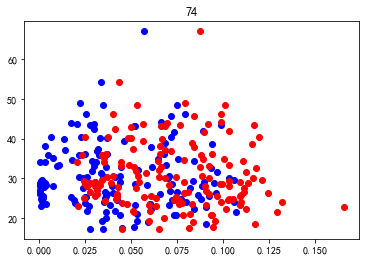

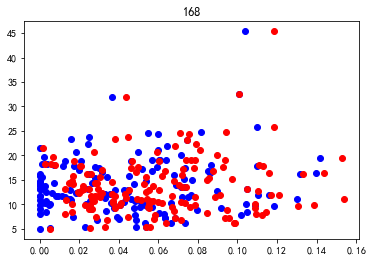

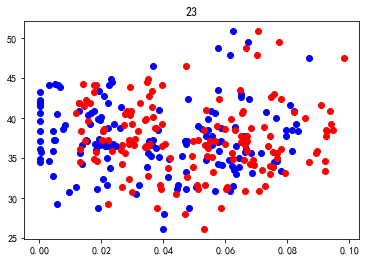

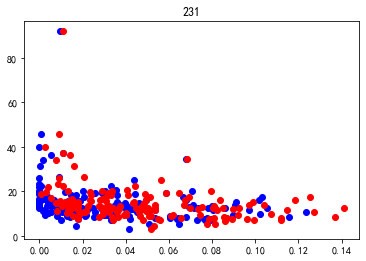

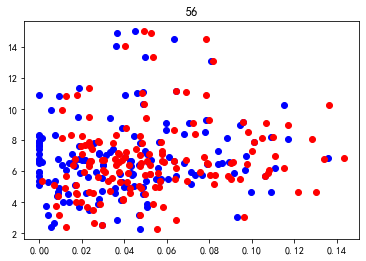

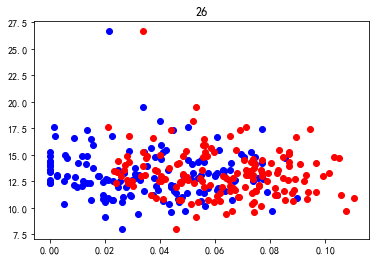

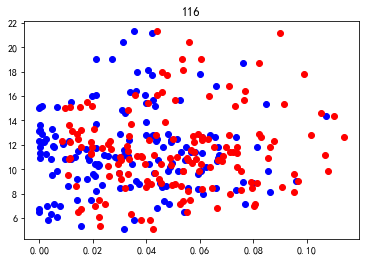

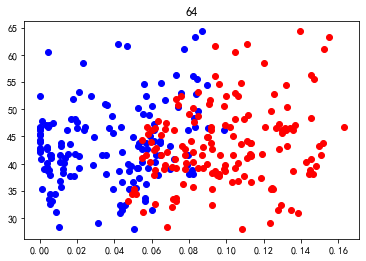

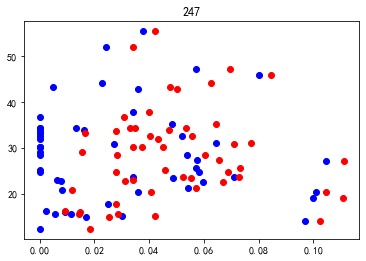

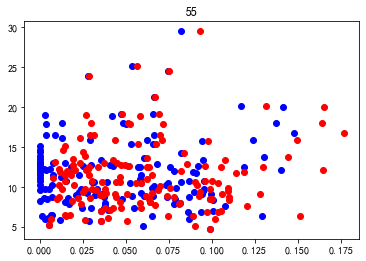

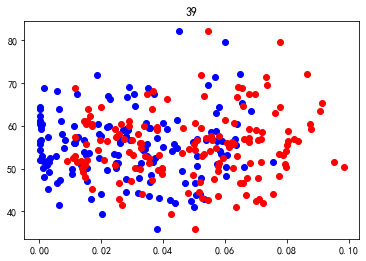

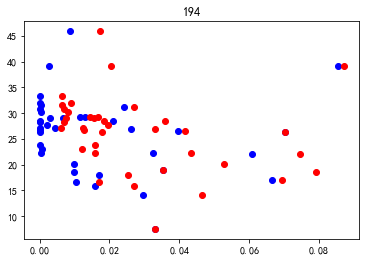

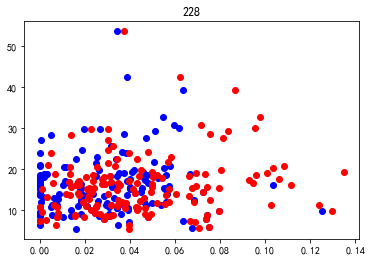

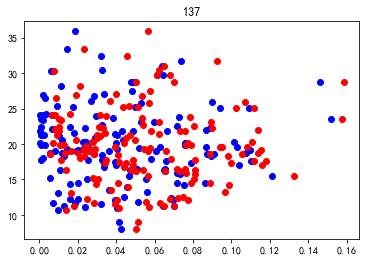

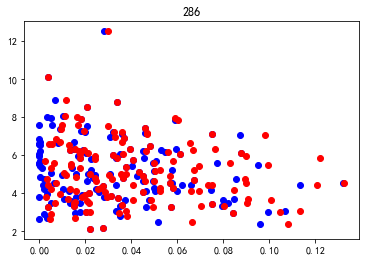

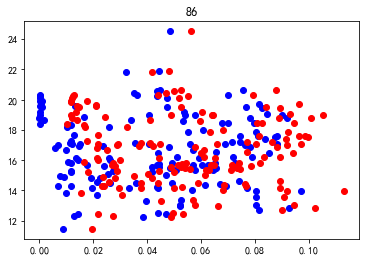

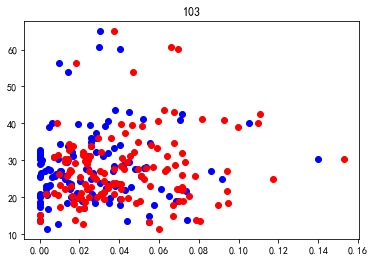

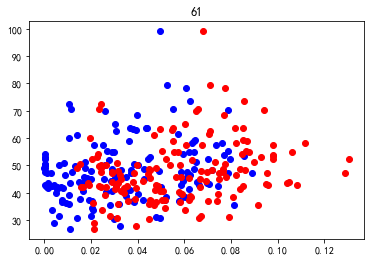

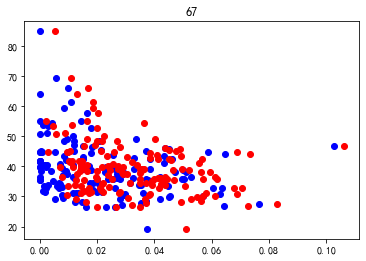

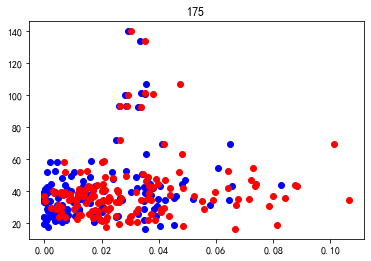

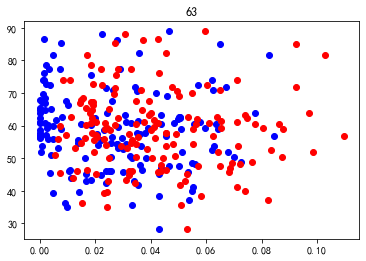

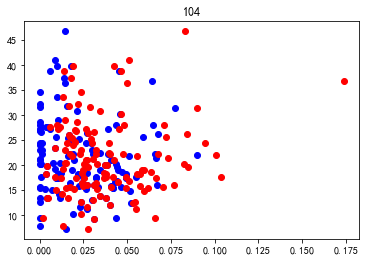

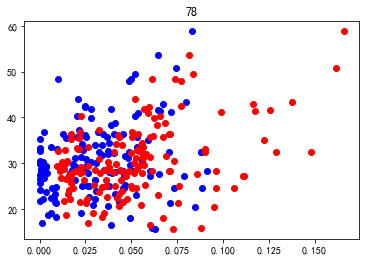

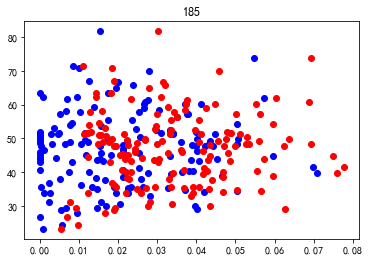

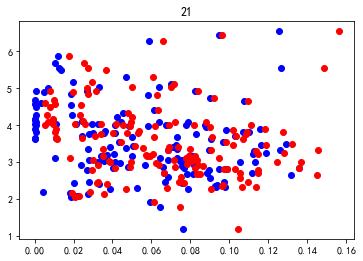

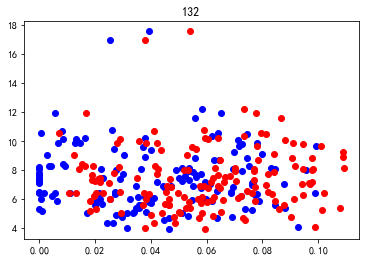

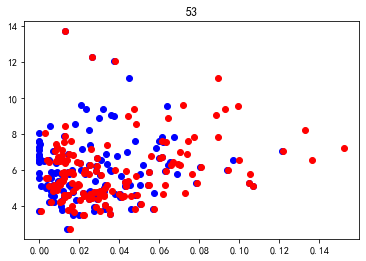

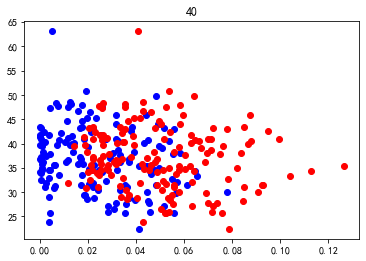

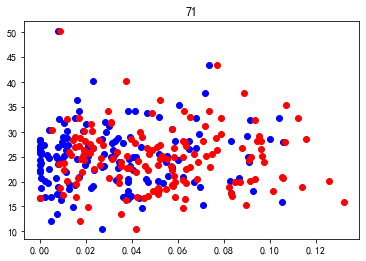

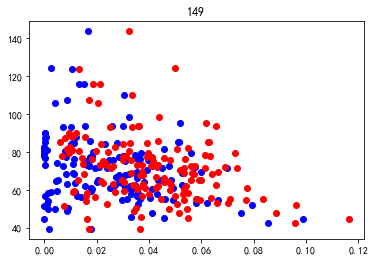

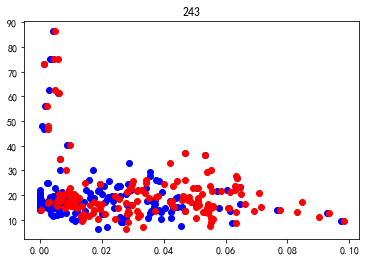

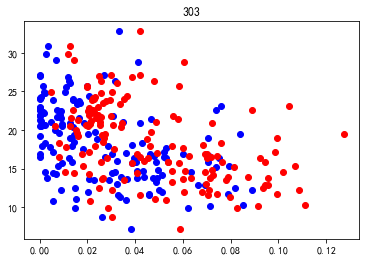

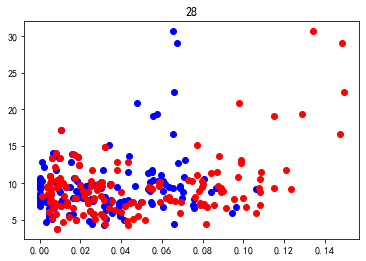

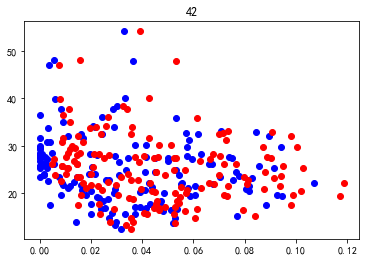

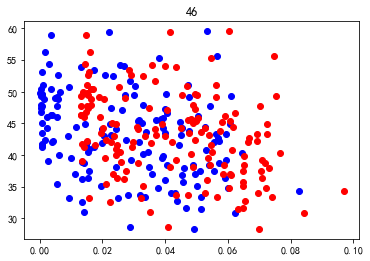

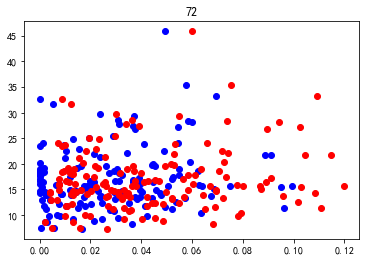

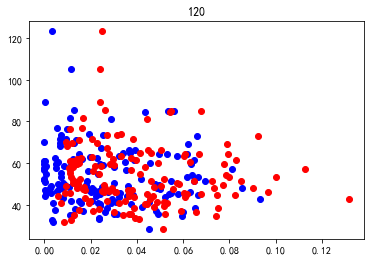

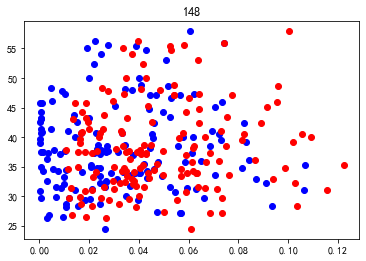

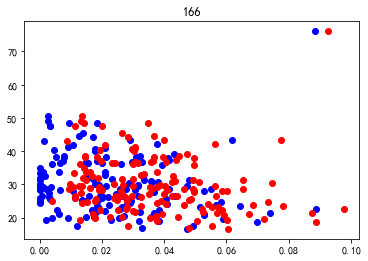

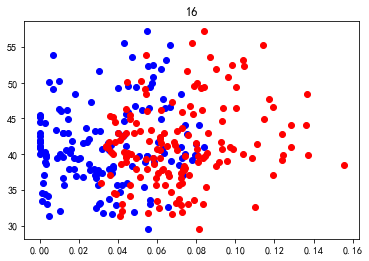

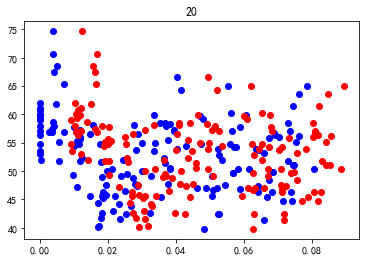

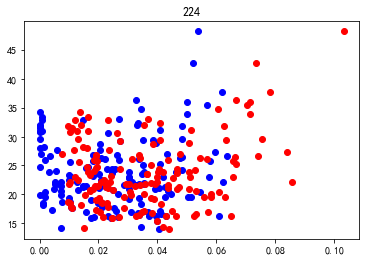

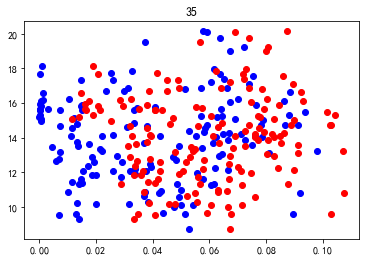

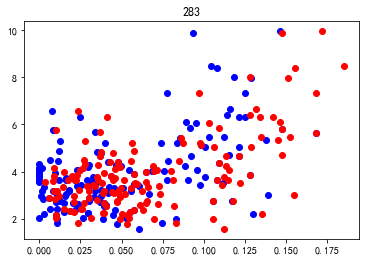

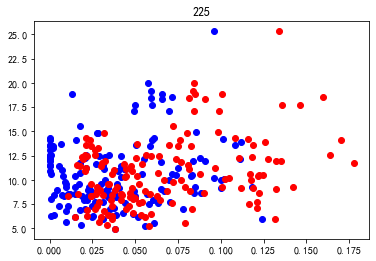

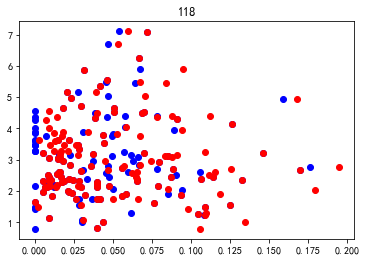

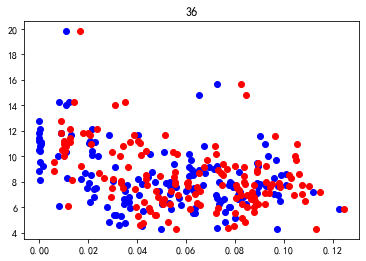

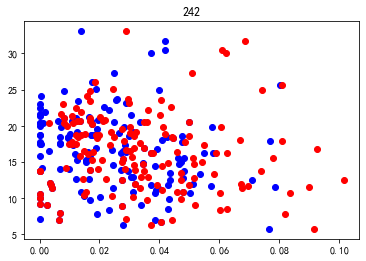

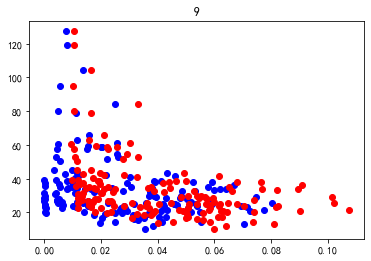

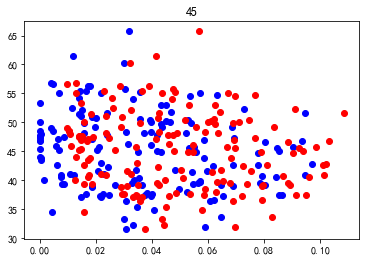

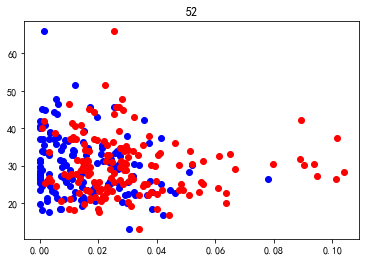

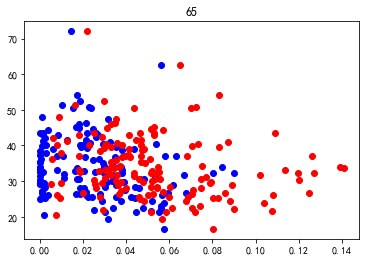

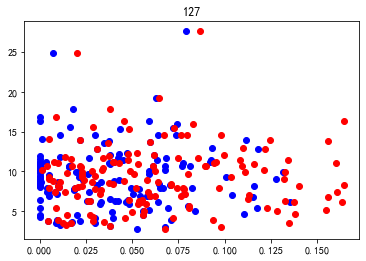

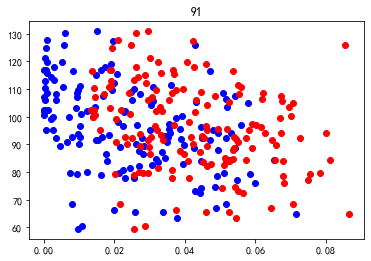

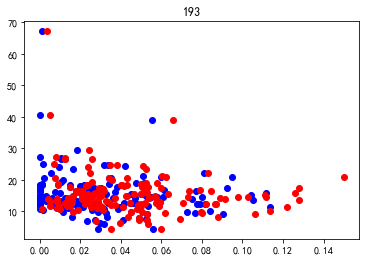

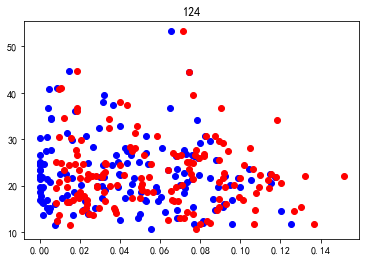

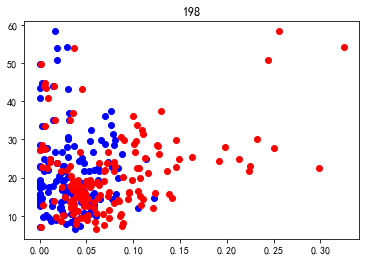

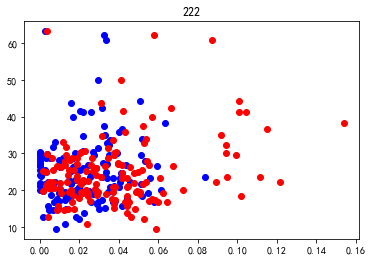

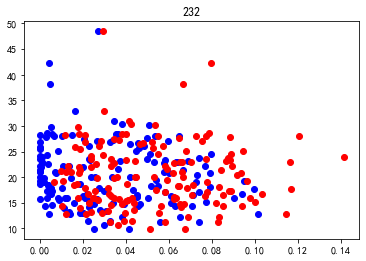

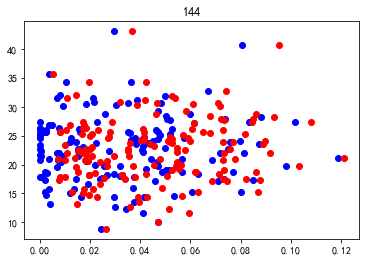

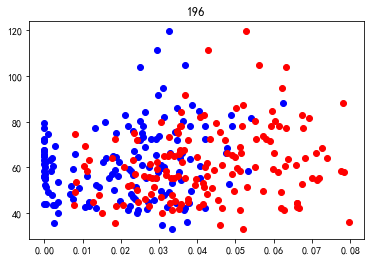

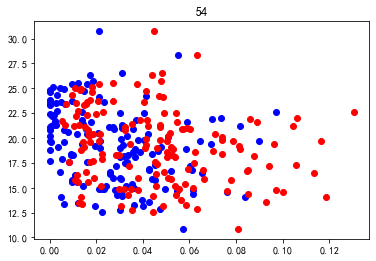

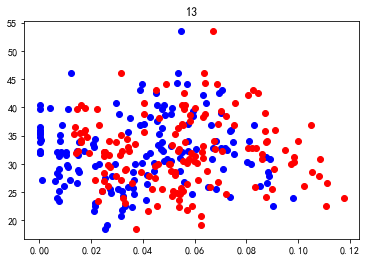

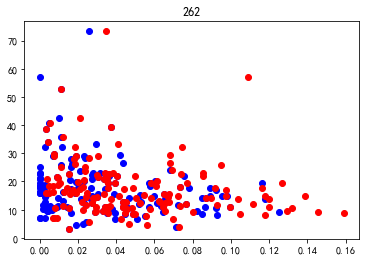

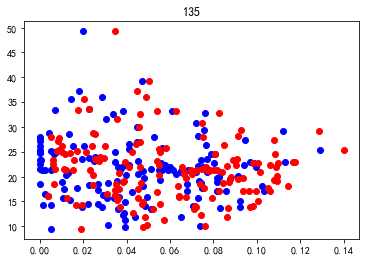

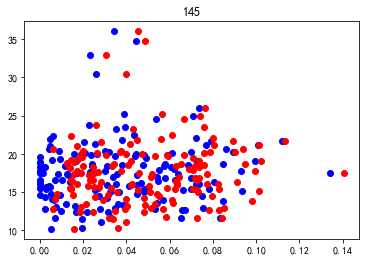

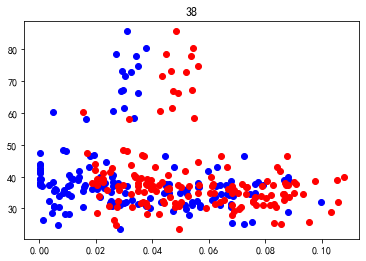

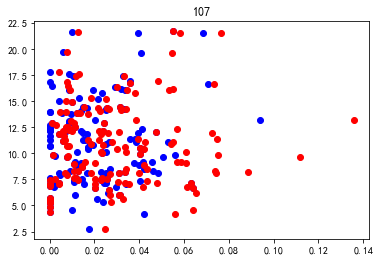

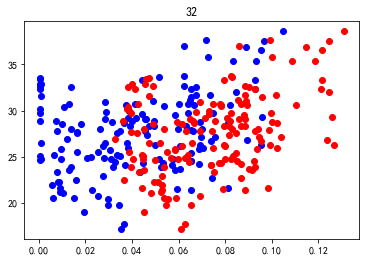

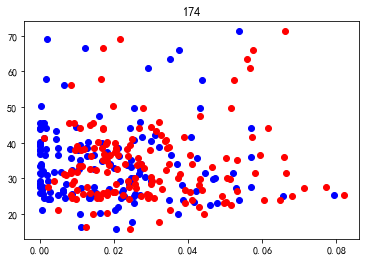

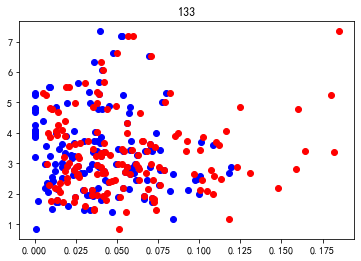

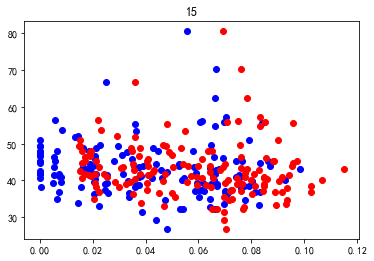

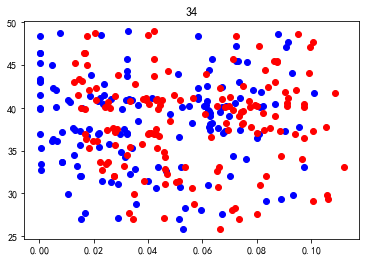

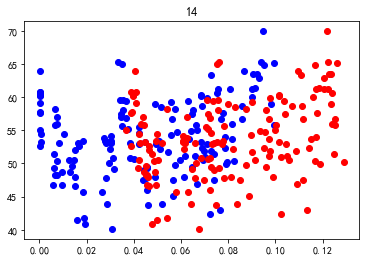

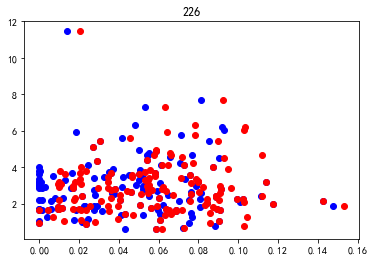

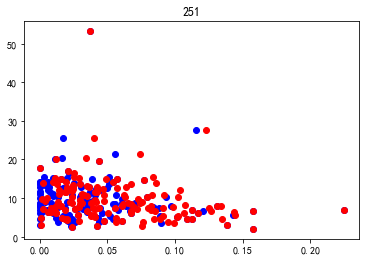

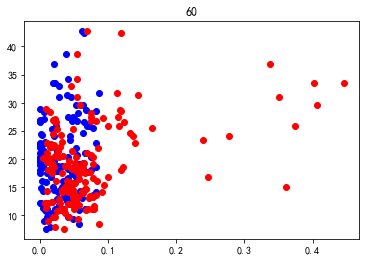

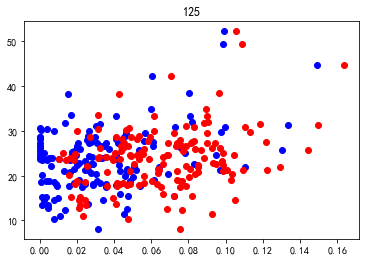

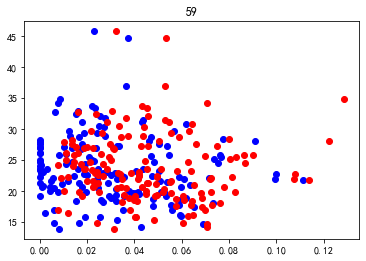

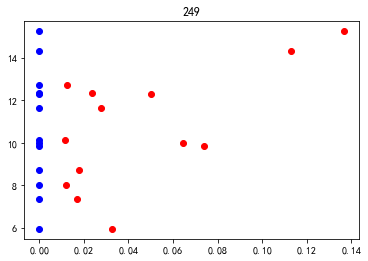

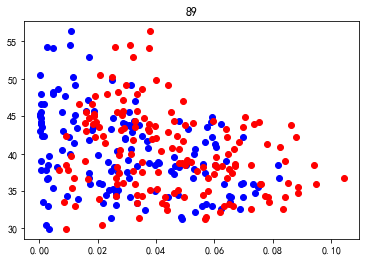

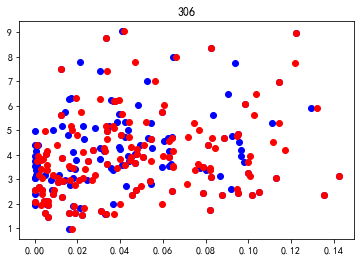

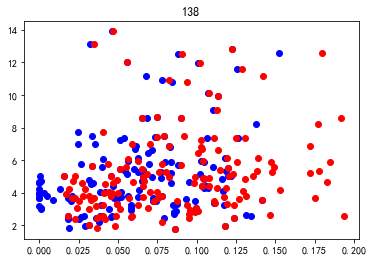

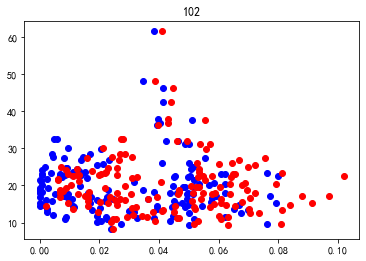

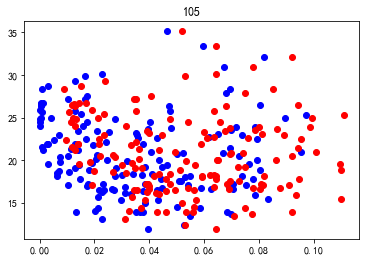

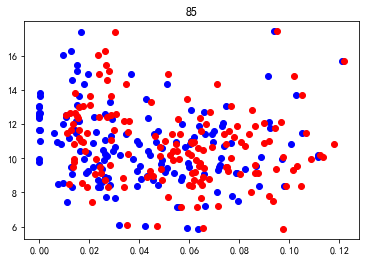

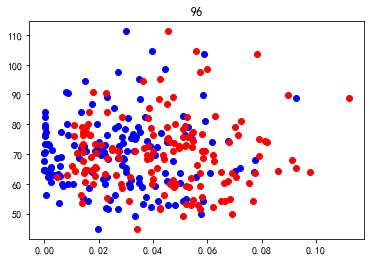

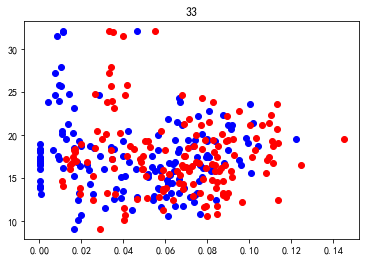

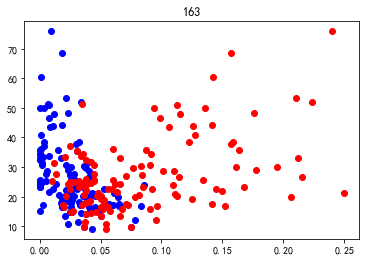

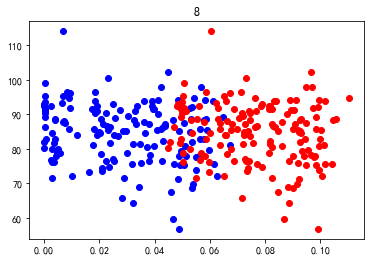

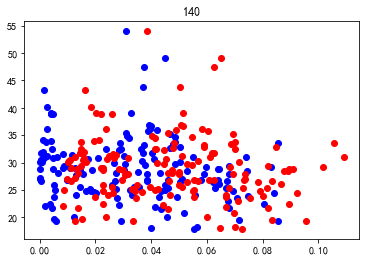

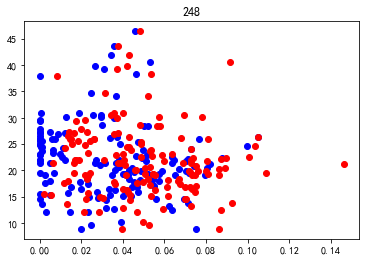

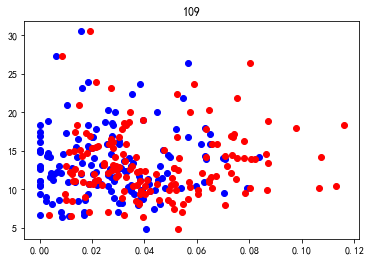

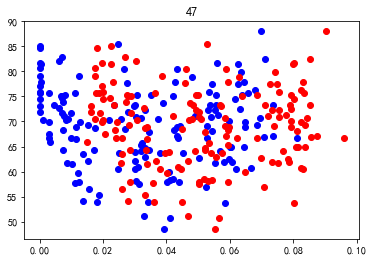

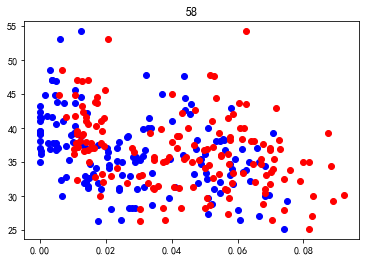

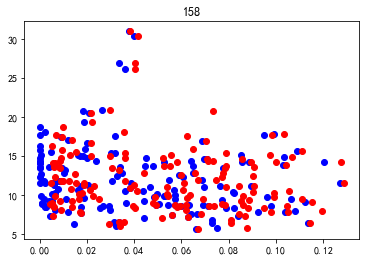

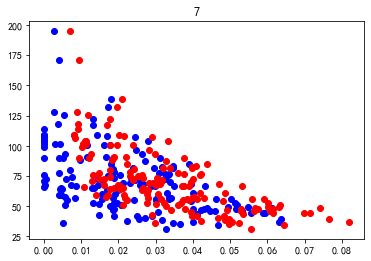

In [26]:
import matplotlib.pyplot as plt
for city_id in city_ids:
    city = df1.loc[df1["city_id"]==city_id][["avg_gmv","hufan_rate","c_hufan_rate"]]
    plt.scatter(city["hufan_rate"],city["avg_gmv"],color="blue")  
    plt.title(str(city_id))
    plt.scatter(city["c_hufan_rate"],city["avg_gmv"],color="red")  
    plt.title(str(city_id))
    plt.show()  


In [27]:
for city_id in city_ids:
    blank =  float(test_dt.loc[(test_dt['city_id'] == city_id)&(test_dt['city_id'] == city_id),"avg_gmv"].mean())
    for group_name in group_names:
        for dt in dt_names:
            num =float(test_dt.loc[(test_dt['city_id'] == city_id)&(test_dt["group_name"] ==group_name )&(test_dt["dt"] ==dt ),"avg_gmv"])
            test_dt.loc[(test_dt['city_id'] == city_id)&(test_dt["group_name"] ==group_name )&(test_dt["dt"] ==dt ),"dgmv_ratio"] = (  num- blank)/blank

In [28]:
df1 = test_dt.query('c_pid_count > 100 and dgmv_ratio > 0 and dgmv_ratio < 0.4 and c_hufan_rate>0.02')

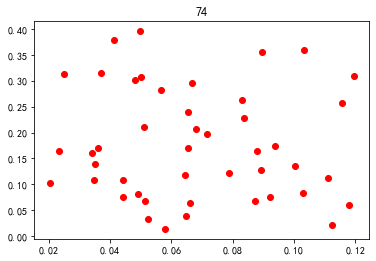

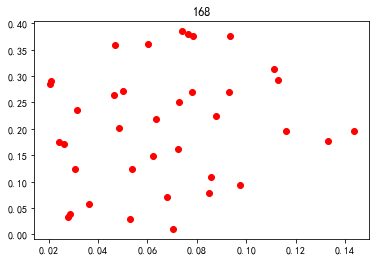

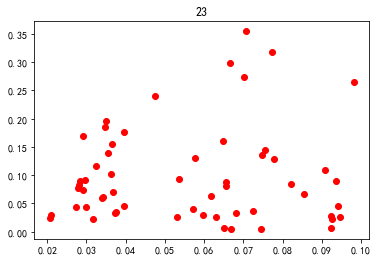

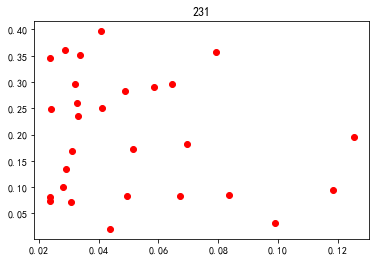

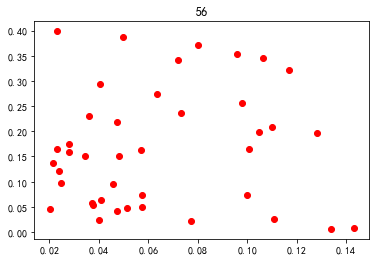

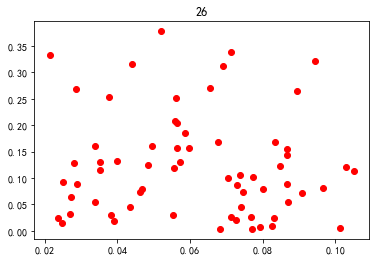

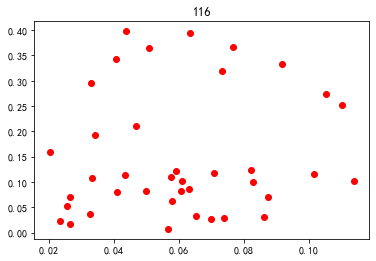

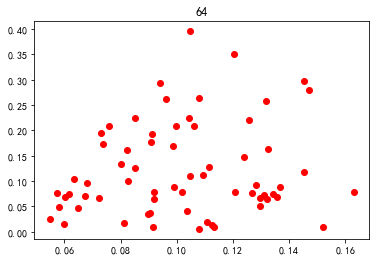

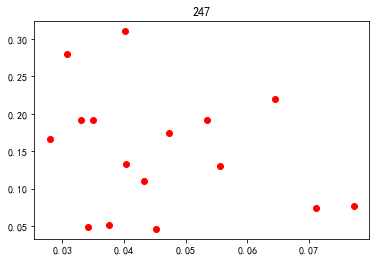

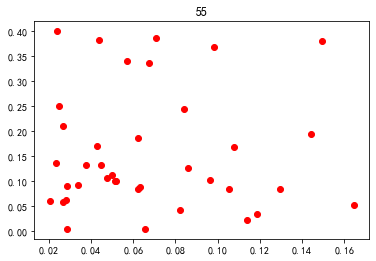

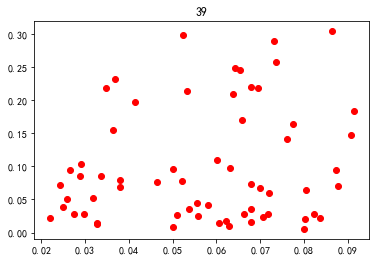

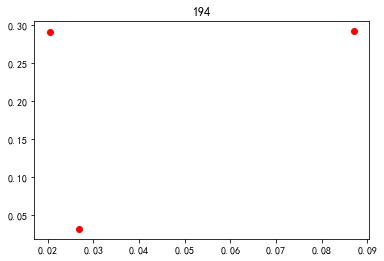

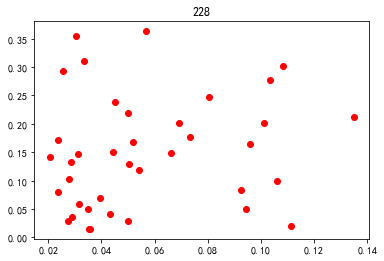

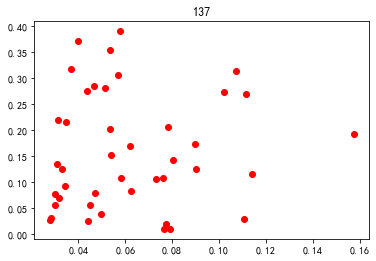

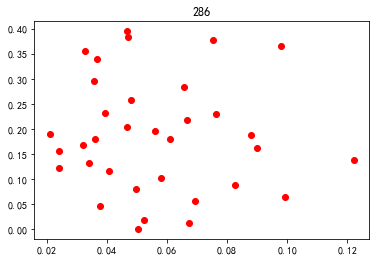

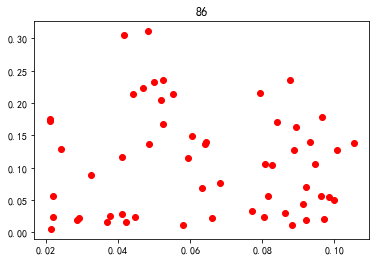

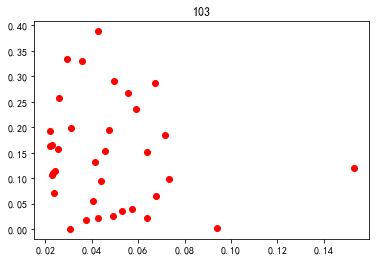

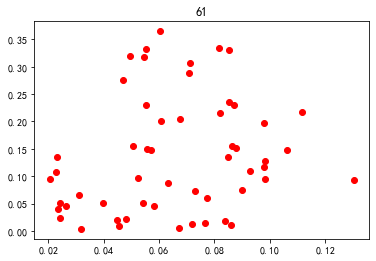

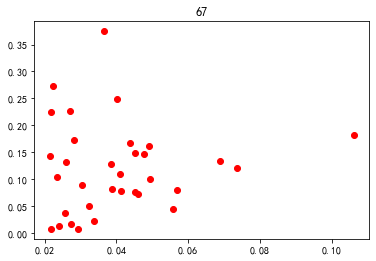

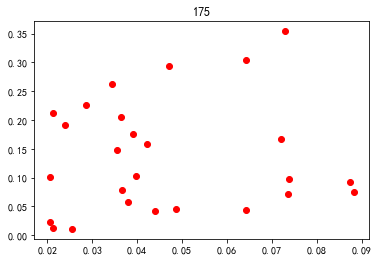

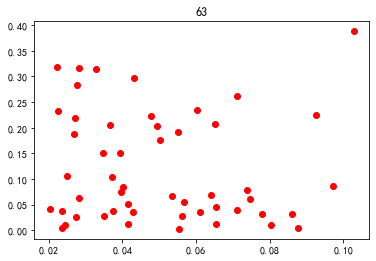

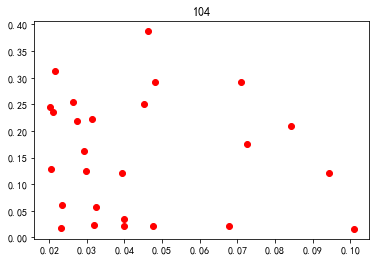

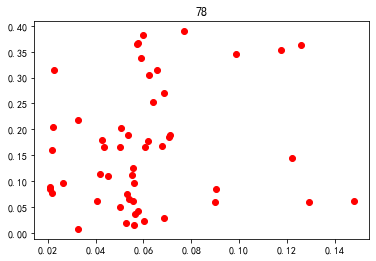

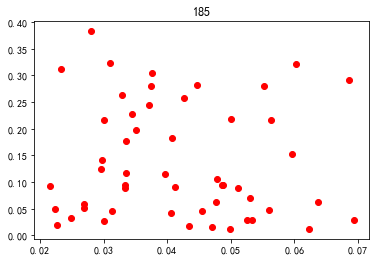

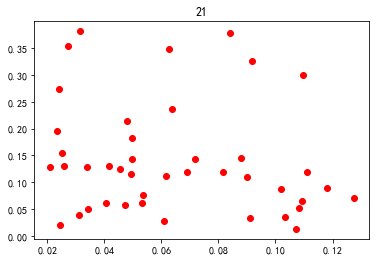

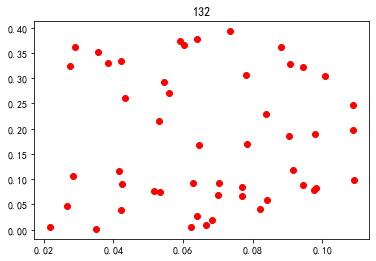

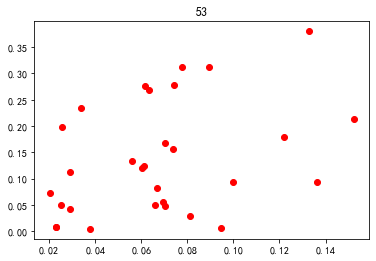

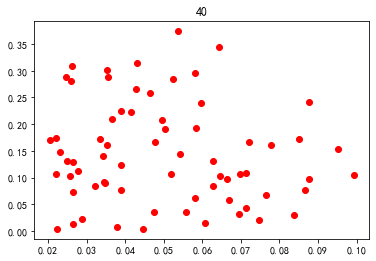

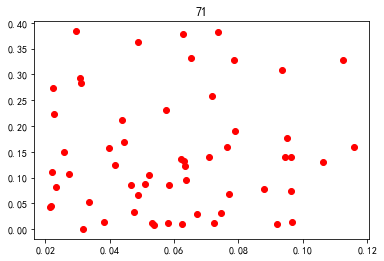

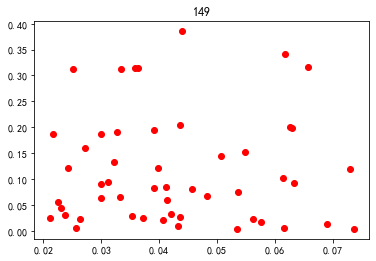

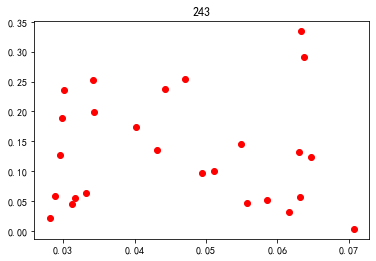

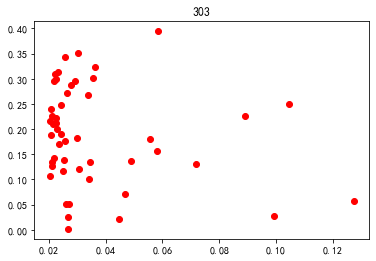

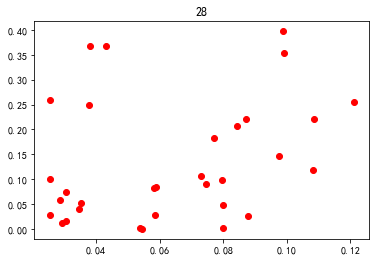

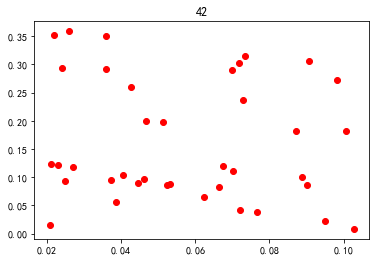

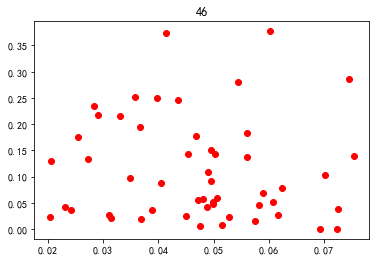

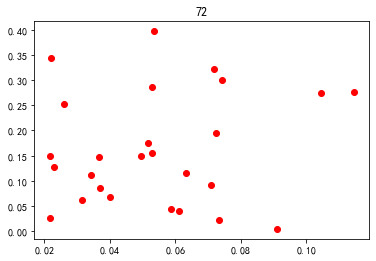

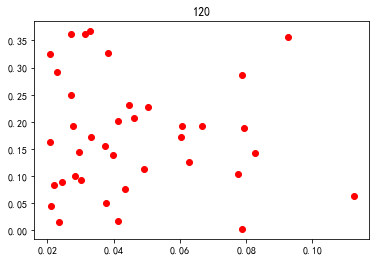

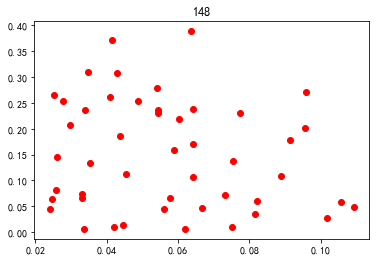

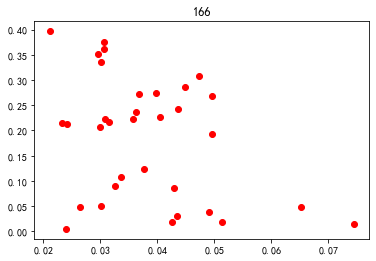

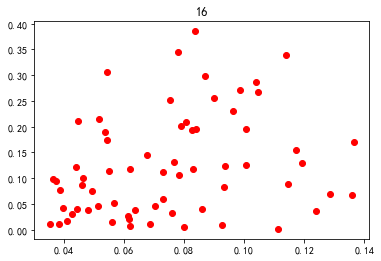

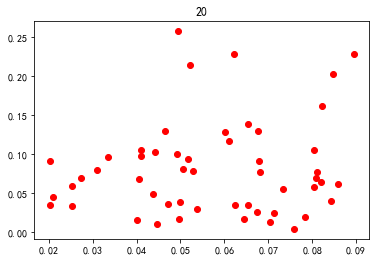

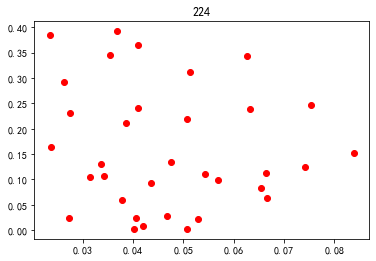

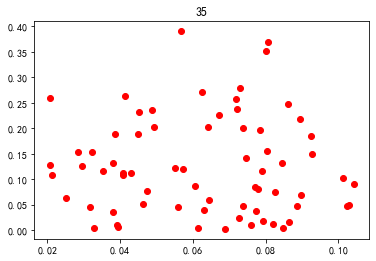

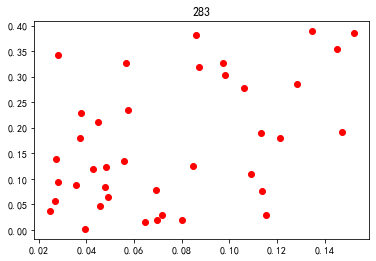

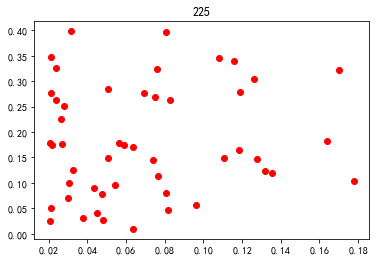

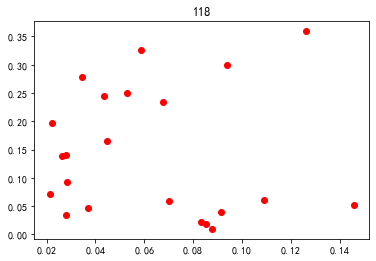

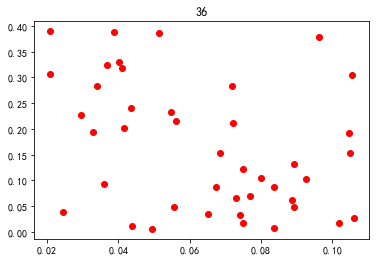

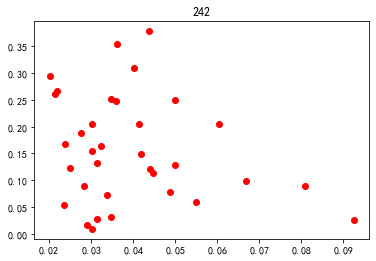

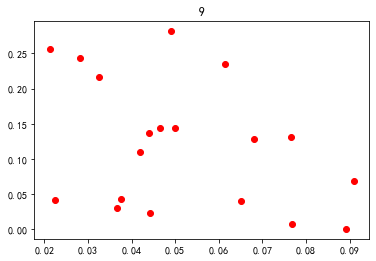

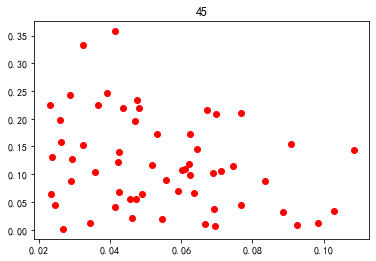

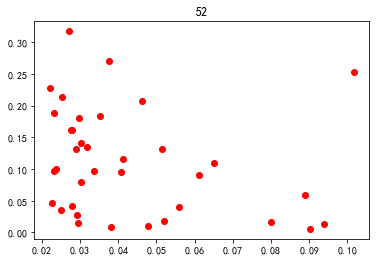

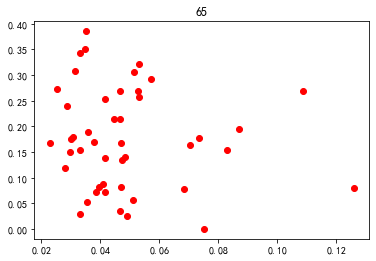

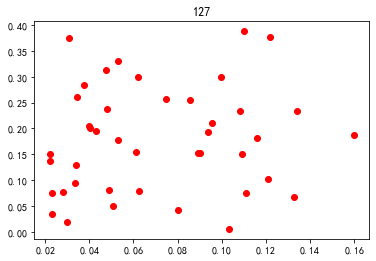

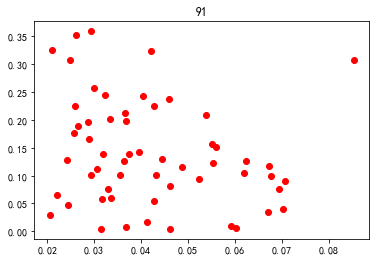

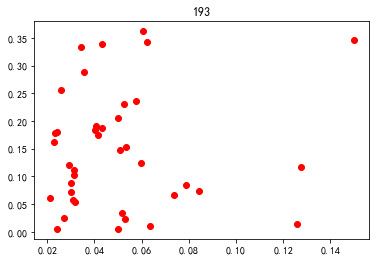

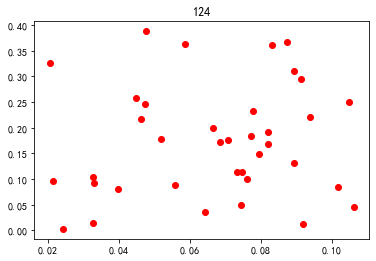

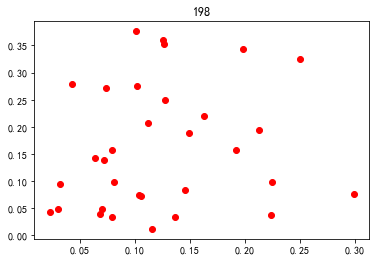

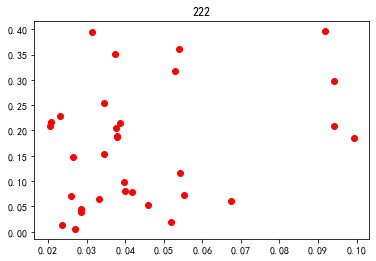

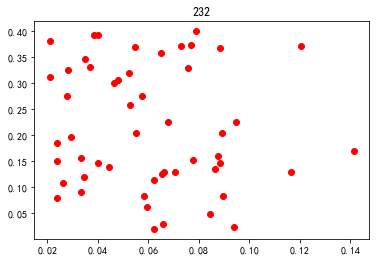

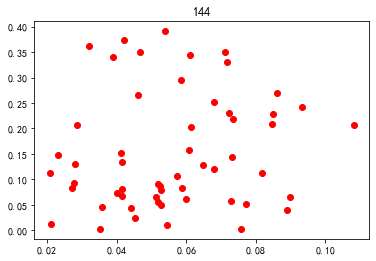

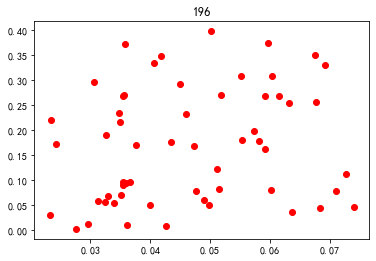

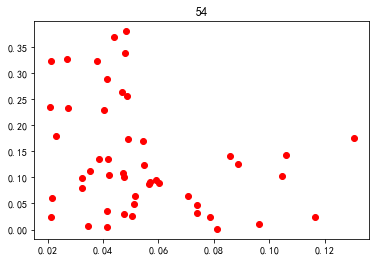

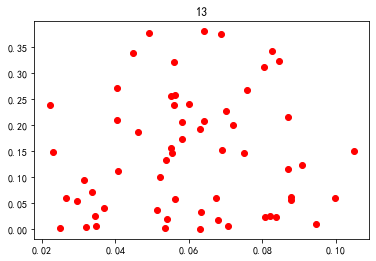

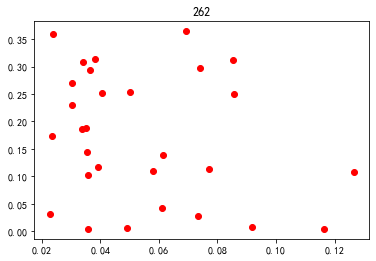

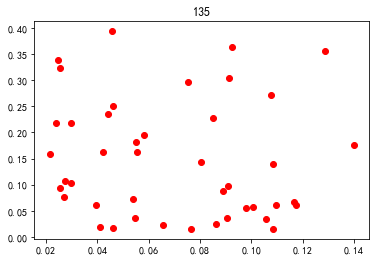

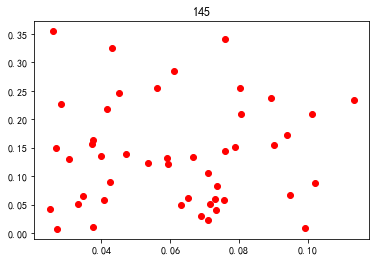

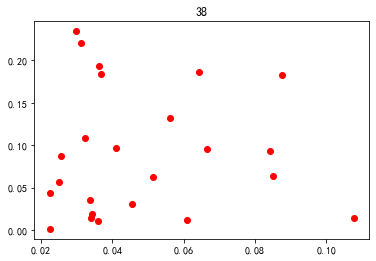

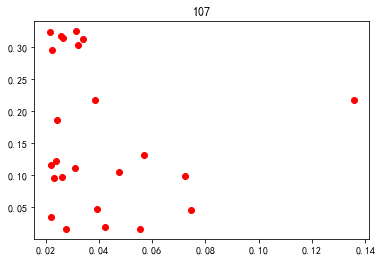

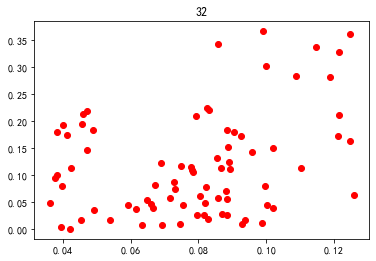

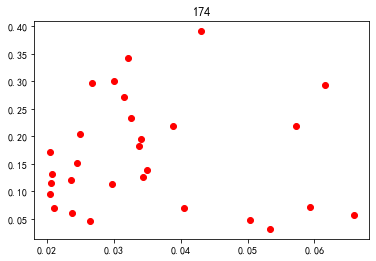

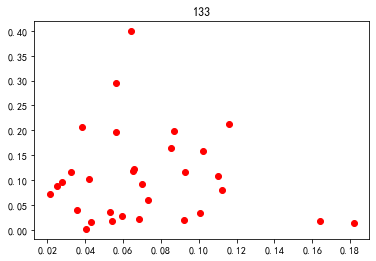

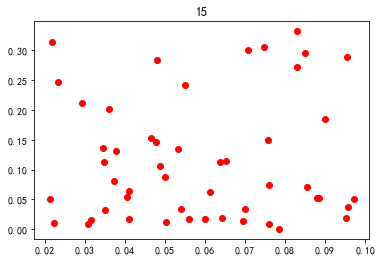

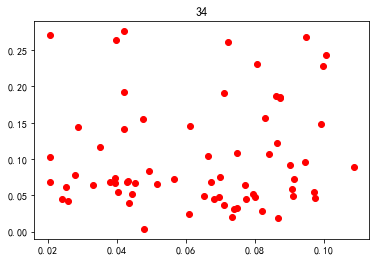

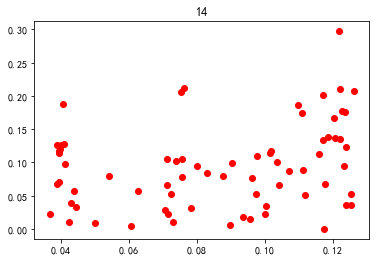

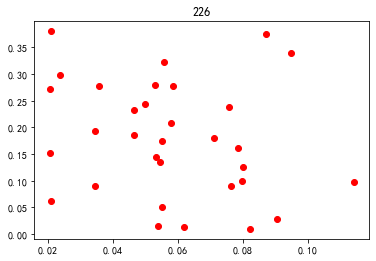

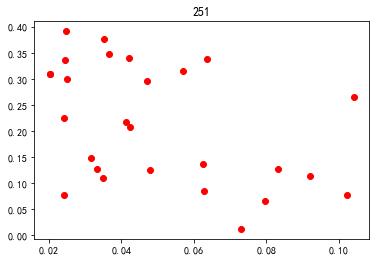

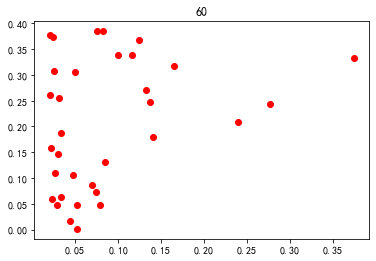

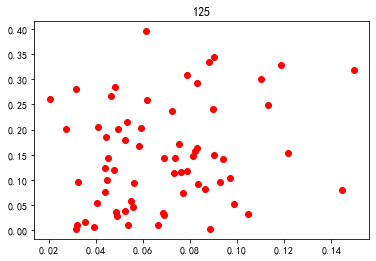

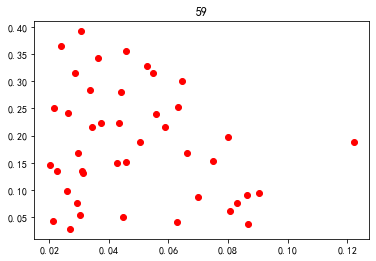

/home/luban/anaconda3/envs/python36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/luban/anaconda3/envs/python36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


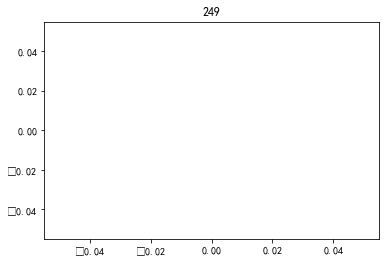

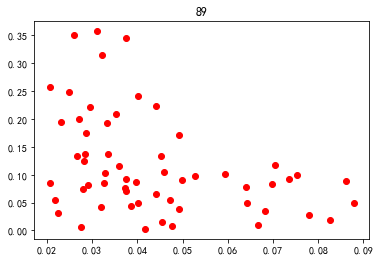

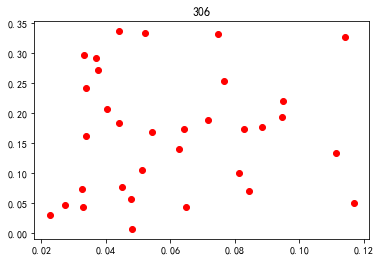

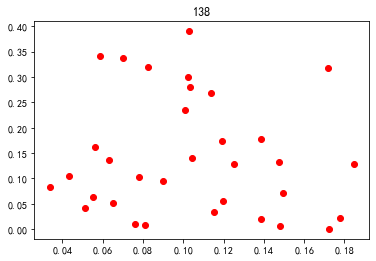

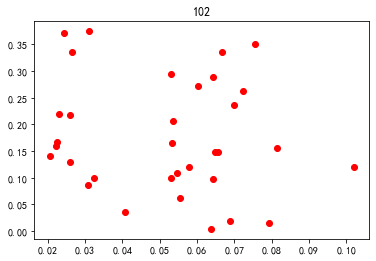

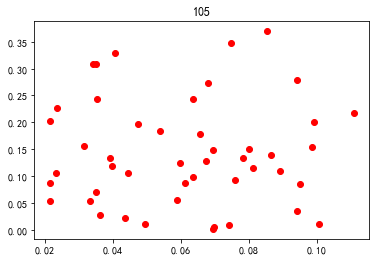

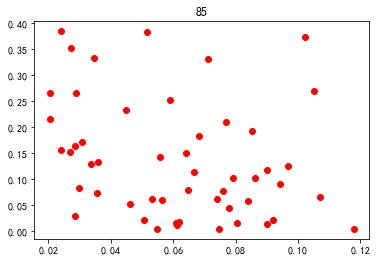

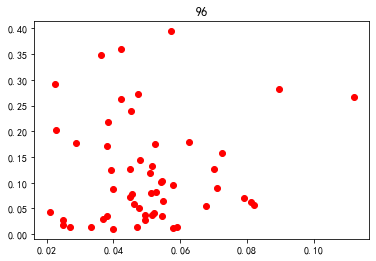

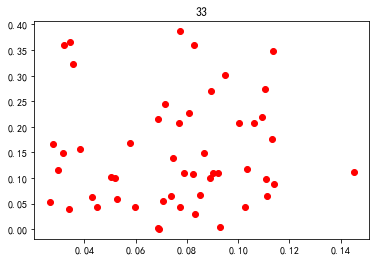

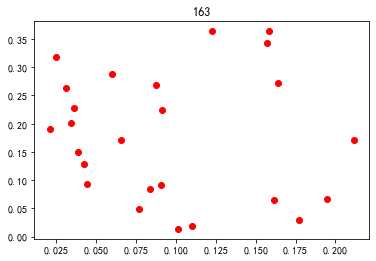

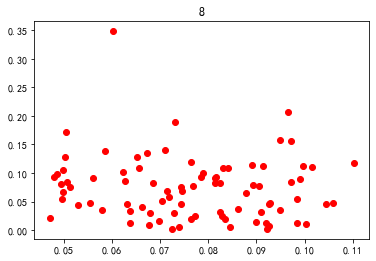

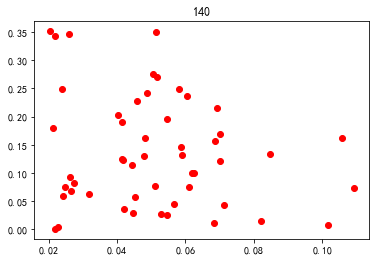

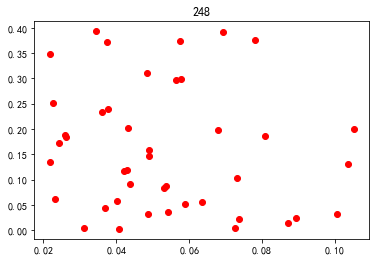

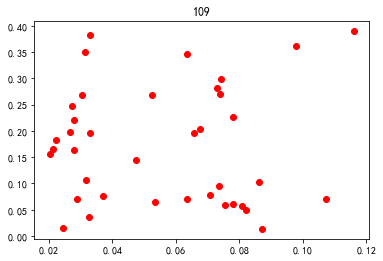

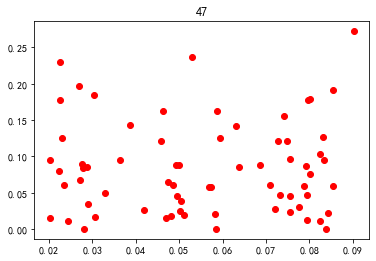

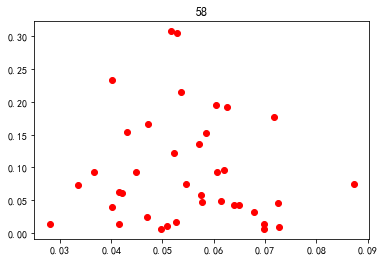

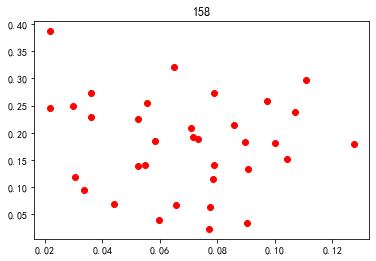

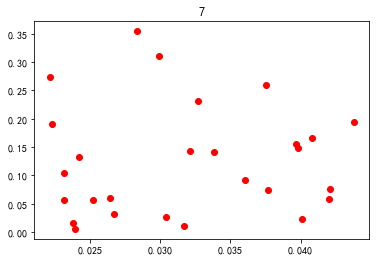

In [29]:
for city_id in city_ids:
    city = df1.loc[df1["city_id"]==city_id][["avg_gmv","dgmv_ratio","hufan_rate","c_hufan_rate"]]
#     plt.scatter(city["hufan_rate"],city["dgmv_ratio"],color="blue")  
#     plt.title(str(city_id))
    plt.scatter(city["c_hufan_rate"],city["dgmv_ratio"],color="red")  
    plt.title(str(city_id))
    plt.show()  


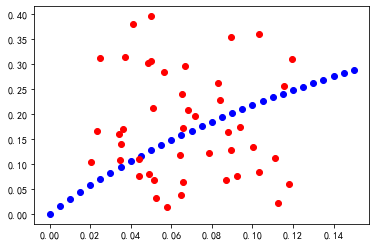

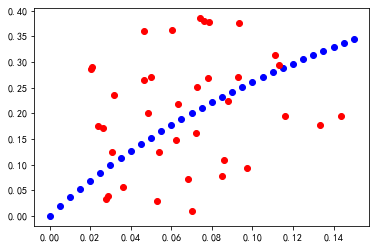

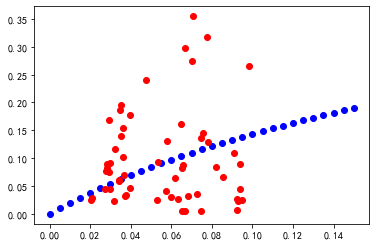

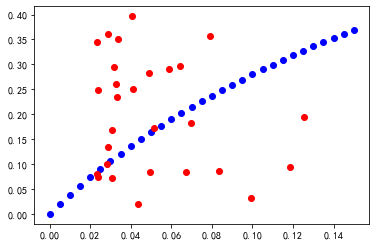

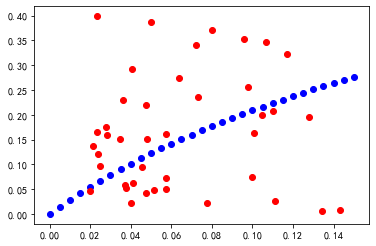

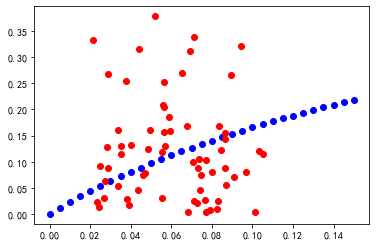

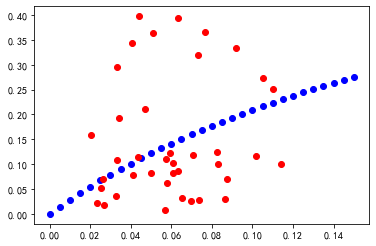

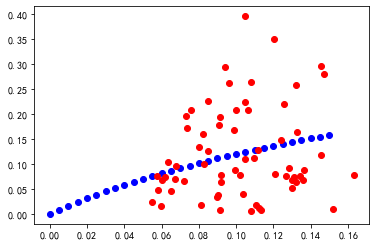

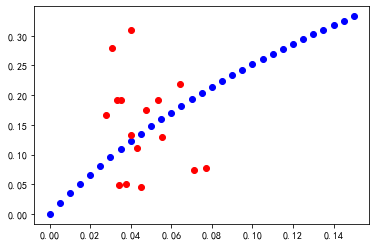

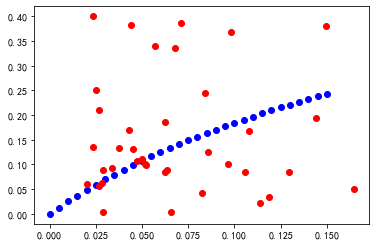

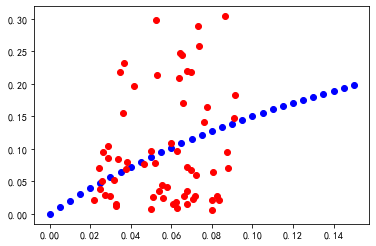

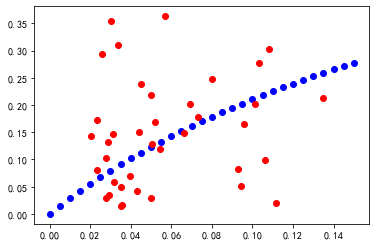

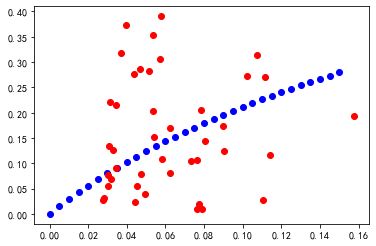

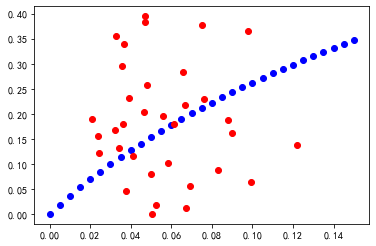

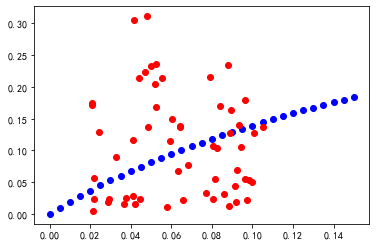

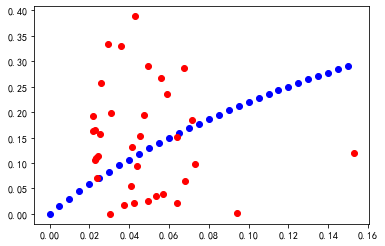

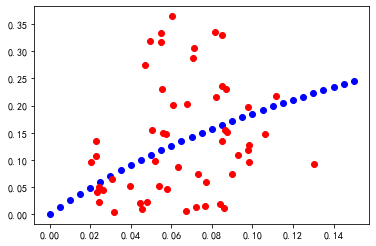

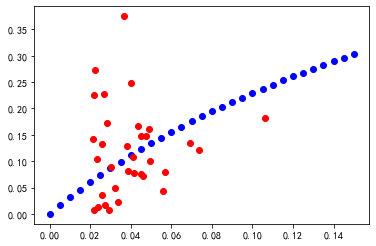

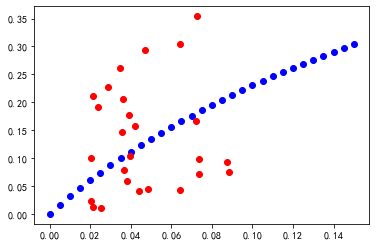

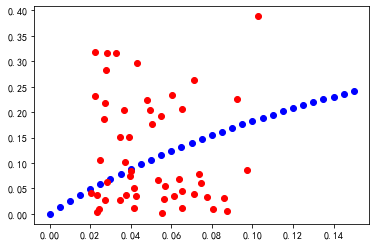

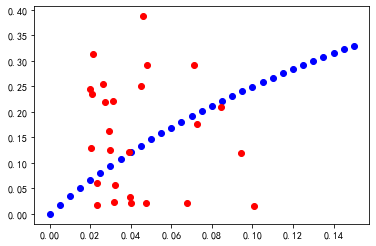

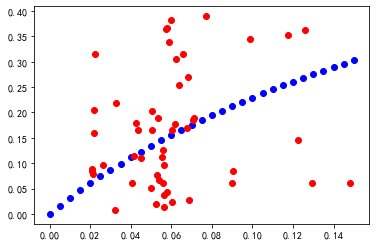

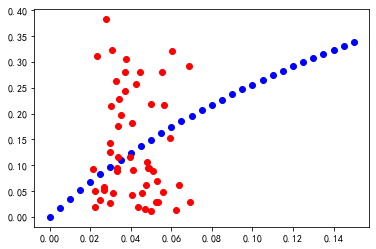

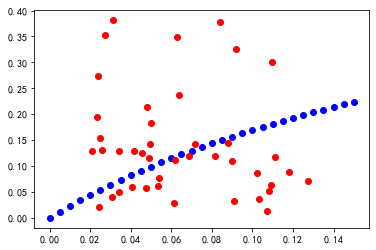

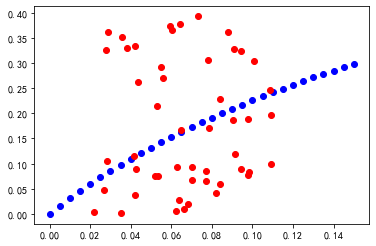

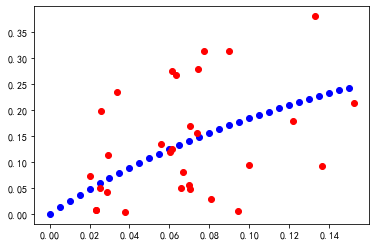

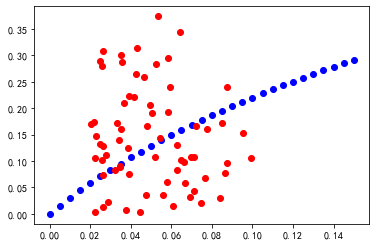

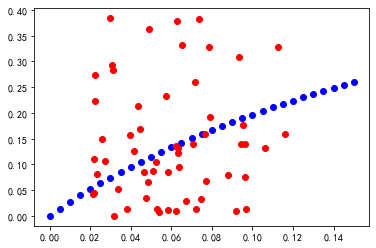

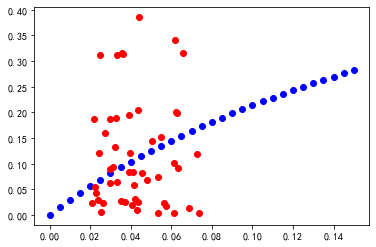

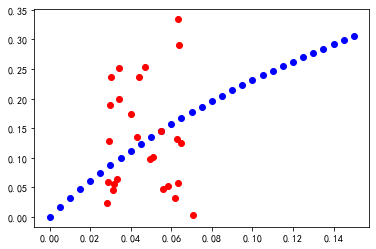

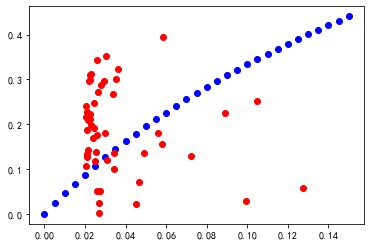

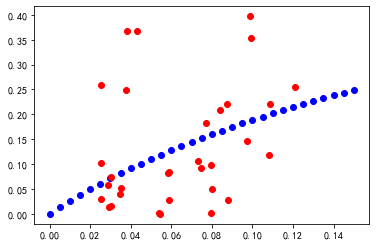

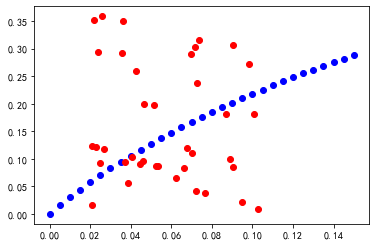

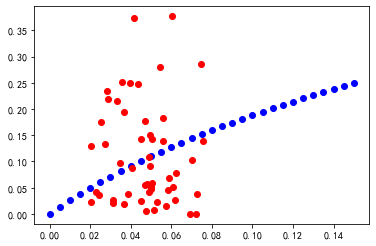

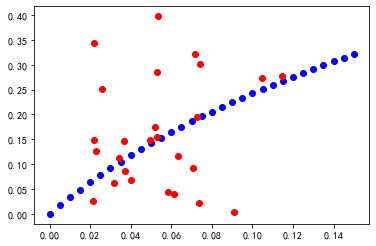

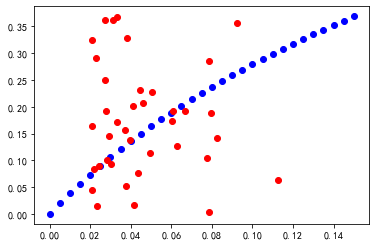

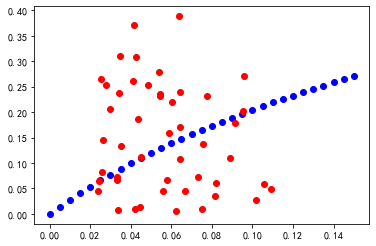

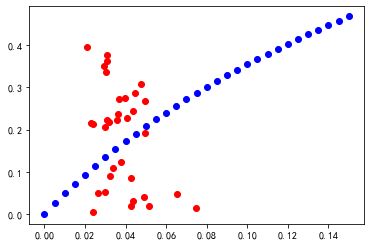

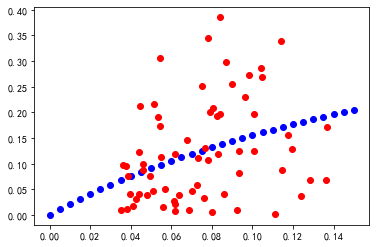

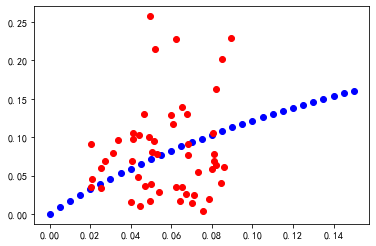

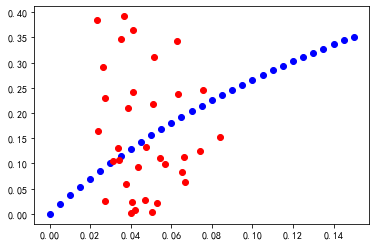

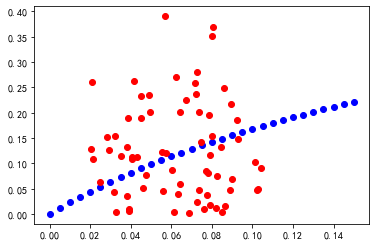

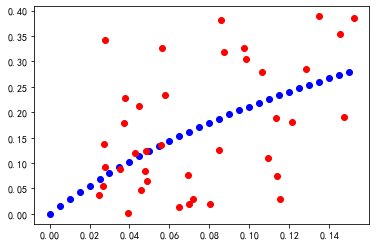

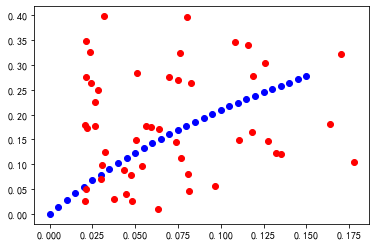

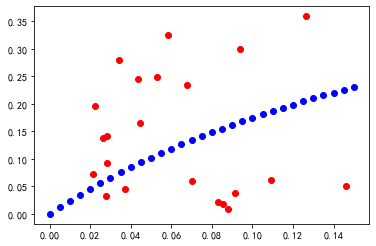

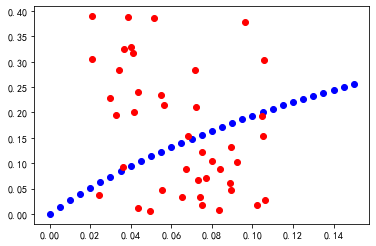

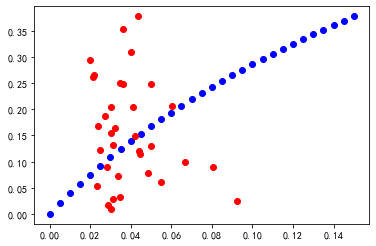

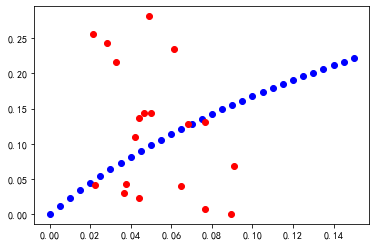

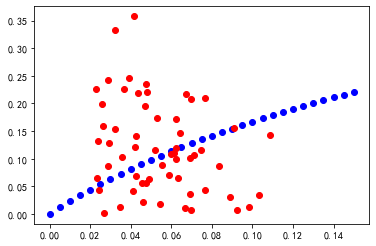

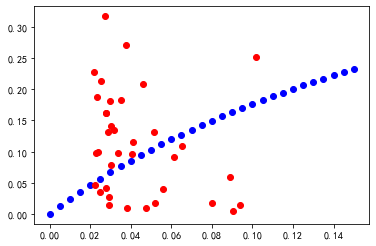

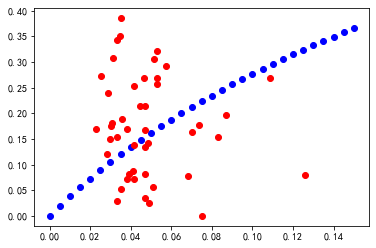

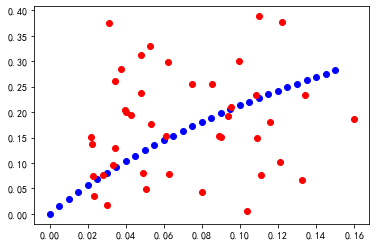

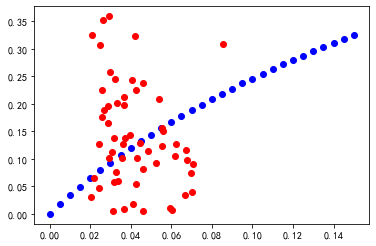

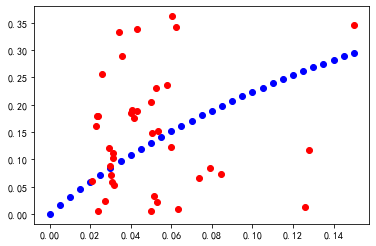

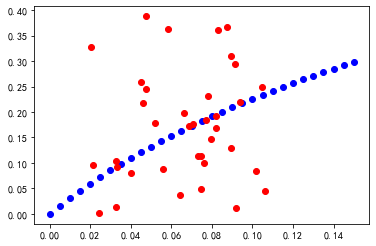

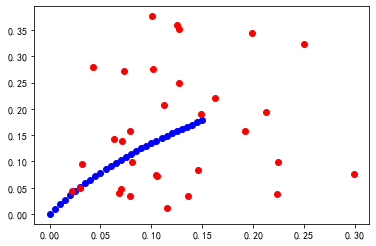

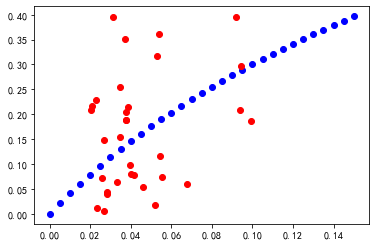

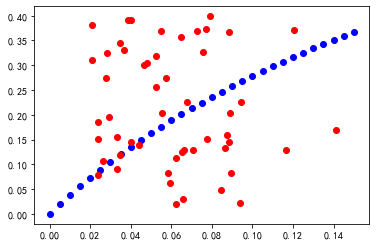

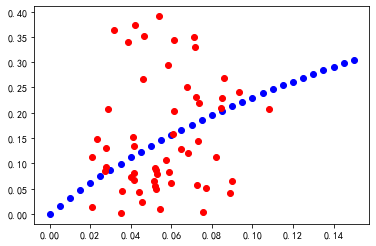

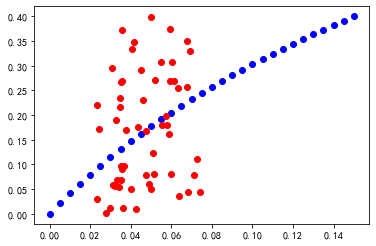

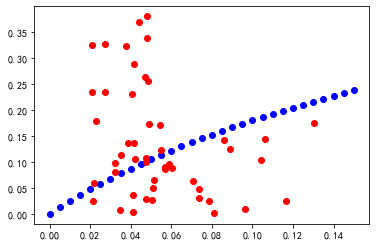

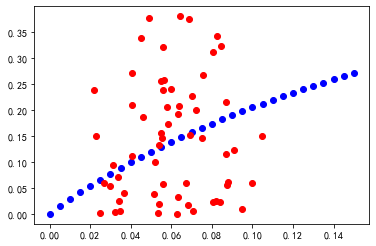

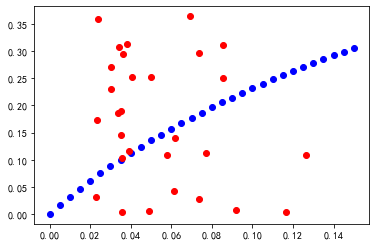

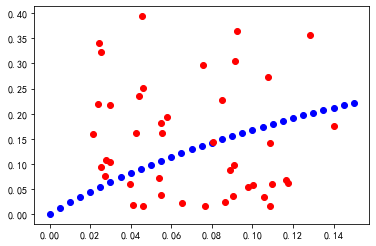

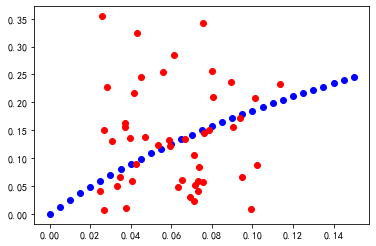

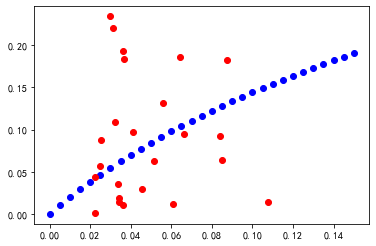

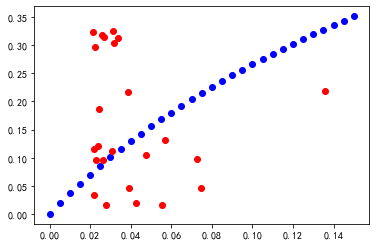

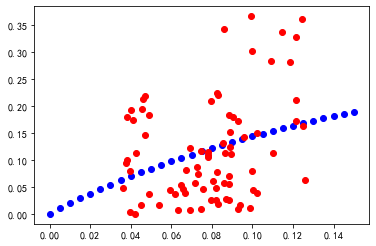

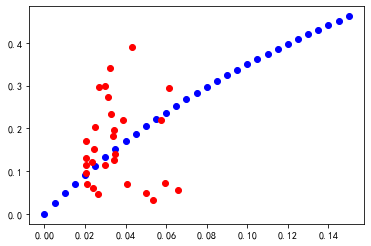

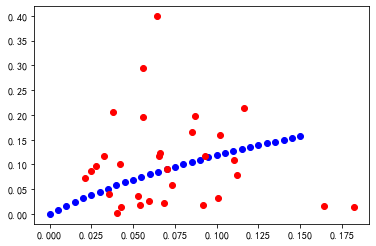

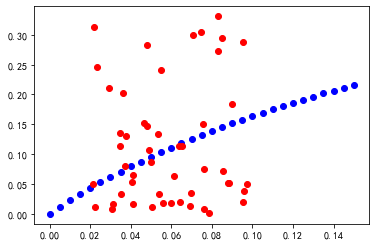

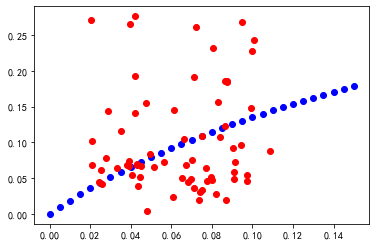

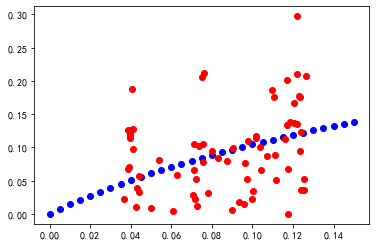

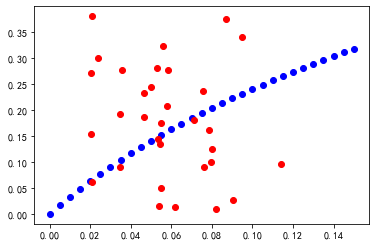

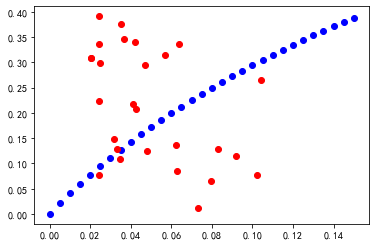

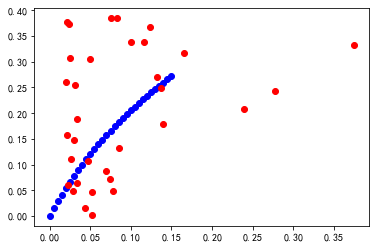

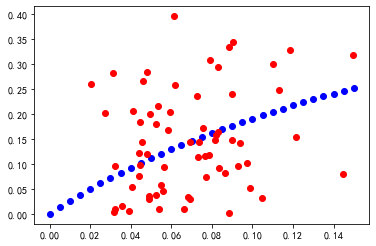

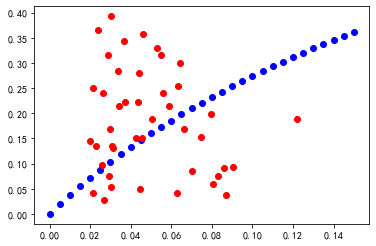

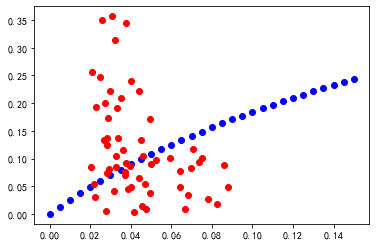

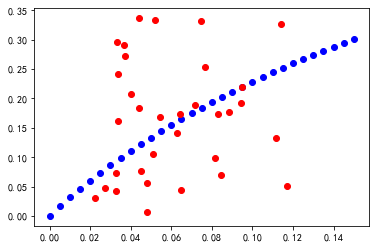

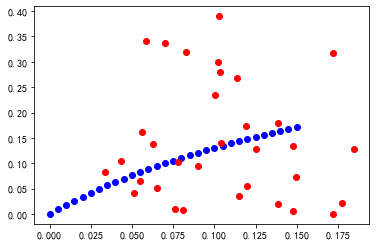

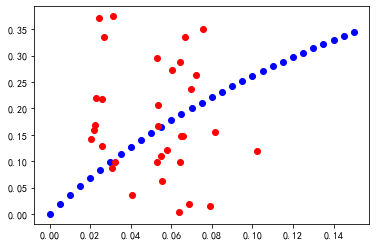

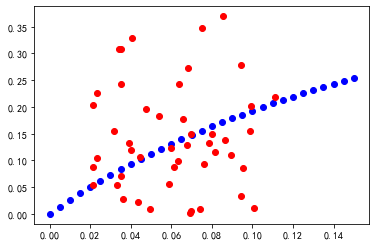

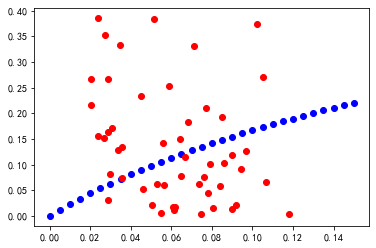

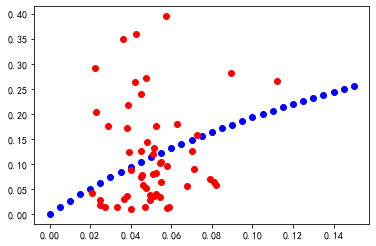

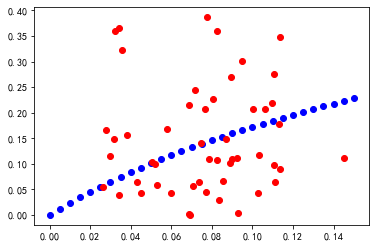

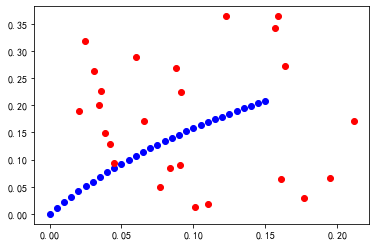

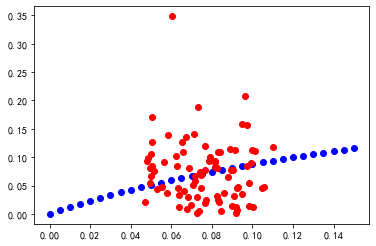

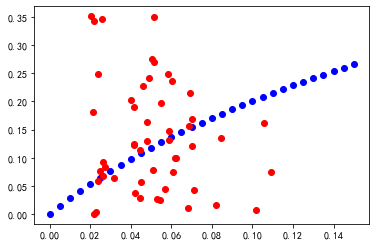

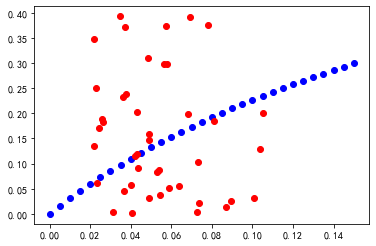

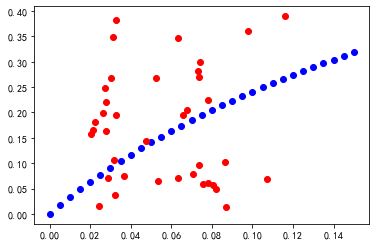

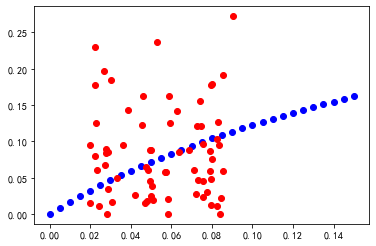

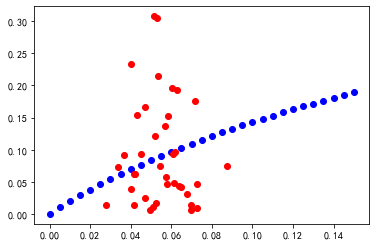

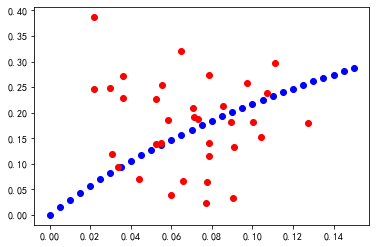

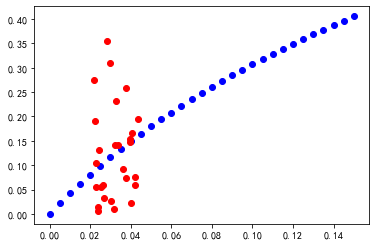

In [30]:
import numpy as np 
from sklearn.linear_model import LinearRegression
result = {}
result_df =  pd.DataFrame()
for city_id in city_ids:
    X_train = df1.loc[df1["city_id"]==city_id][["c_hufan_rate"]]
    Y_train = df1.loc[df1["city_id"]==city_id][["dgmv_ratio"]]
    if X_train.shape[0] < 10:
        result[city_id] = 0.107
        X_test = np.arange(0, 0.15 + 0.005, 0.005).reshape((31,1))
        X_ln = np.log(10*X_test + 1)
        Y_test =  X_ln*0.107
        end  =pd.DataFrame({"c_hufan_rate":list(X_test),"dgmv_ratio":list(Y_test)})
        end['c_hufan_rate'] = end['c_hufan_rate'].apply(lambda x: x[0])
        end['dgmv_ratio'] = end['dgmv_ratio'].apply(lambda x: x[0])
        end["city_id"] = int(city_id)
        result_df = pd.concat([result_df, end], axis=0)
    else:
        X_train1 = X_train.applymap(lambda x: np.log(10*x + 1))
        lineModel = LinearRegression(fit_intercept = False)
        lineModel.fit(X_train1,Y_train)
        X_test = np.arange(0, 0.15 + 0.005, 0.005).reshape((31,1))
        X_ln = np.log(10*X_test + 1)
        Y_test =  lineModel.predict(X_ln)
        end  =pd.DataFrame({"c_hufan_rate":list(X_test),"dgmv_ratio":list(Y_test)})
        end['c_hufan_rate'] = end['c_hufan_rate'].apply(lambda x: x[0])
        end['dgmv_ratio'] = end['dgmv_ratio'].apply(lambda x: x[0])
        end["city_id"] = int(city_id)
        result_df = pd.concat([result_df, end], axis=0)
        plt.scatter(X_test,Y_test,color="blue")  
        plt.scatter(X_train,Y_train,color="red")  
        plt.show() 
        result[city_id] = format(lineModel.coef_[0,0],".3f")


In [31]:
# 出租车弹性
result_df

,c_hufan_rate,dgmv_ratio,city_id
0,0.000,0.000000,74
1,0.005,0.015305,74
2,0.010,0.029898,74
3,0.015,0.043842,74
4,0.020,0.057193,74
...,...,...,...
26,0.130,0.368706,7
27,0.135,0.378226,7
28,0.140,0.387546,7
29,0.145,0.396673,7


In [21]:
test2 = test1.groupby(['group_name']).sum().reset_index()
test2["avg_gmv"] = test2.apply( lambda x:0 if  x['c_pid_count'] == 0 or x["c_gmv"] == 0 else float(format(x['c_gmv'] / x['c_pid_count'],".4f")), axis=1)
test2["avg_csubsidy"] = test2.apply( lambda x:0 if  x['c_pid_count'] == 0 or x["c_gmv"] == 0 else float(format(x['c_subsidy_c'] / x['c_pid_count'],".4f")), axis=1)
test2["avg_hufan"] = test2.apply( lambda x:0 if  x['c_pid_count'] == 0 or x["c_gmv"] == 0 else float(format(x['c_subsidy_hufan'] / x['c_pid_count'],".4f")), axis=1)
test2["c_hufan_rate"] = test2.apply( lambda x: float(format(x['avg_csubsidy'] / x['avg_gmv'],".4f")), axis=1)
min_all = min(test2["avg_gmv"])
test2["dgmv_ratio"] = test2.apply( lambda x:float(format((x['avg_gmv'] -min_all) / x['avg_gmv'],".4f")), axis=1)
df3 = test2.query("dgmv_ratio < 0.1")
import matplotlib.pyplot as plt
plt.scatter(df3["c_hufan_rate"],df3["dgmv_ratio"],color="red")  
plt.show()  


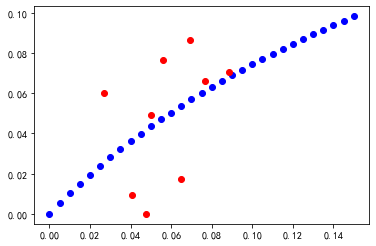

In [98]:
#全国
X_train = df3[["c_hufan_rate"]]
Y_train = df3[["dgmv_ratio"]]
X_train1 = X_train.applymap(lambda x: np.log(10*x + 1))
lineModel = LinearRegression(fit_intercept = False)
lineModel.fit(X_train1,Y_train)
X_test = np.arange(0, 0.15 + 0.005, 0.005).reshape((31,1))
X_ln = np.log(10*X_test + 1)
Y_test =  lineModel.predict(X_ln)
plt.scatter(X_test,Y_test,color="blue")  
plt.scatter(X_train,Y_train,color="red") 
print(lineModel.coef_[0,0])
print(lineModel.score(X_train1,Y_train))

In [99]:
print(lineModel.coef_[0,0])
print(lineModel.score(X_train1,Y_train))

0.10729026728404484
0.15158705864501232
